# Intro to Deep Learning Systems: Lab 3

In [1]:
import torch, torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as transF
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Utils
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
class Cutout(object):
    """
    Randomly mask out one or more patches from an image.
    taken from https://github.com/uoguelph-mlrg/Cutout
    Args:
        holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """

    def __init__(self, holes, length):
        self.holes = holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

## Batch Augmentation, Cutout Regularization 
### Q4.1
**Cutout** is a regularization technique for convolutional neural networks where we essentially generate more training samples by creating versions of existing training input samples by removing a **contiguous sections**, thereby improving the generalization of the model by forcing it to focus more on generic minor features rather than local and specific major features of an image.

#### Advantages of Cutout over Simple Dropout
Cutout improves upon simple dropout due to the fact that the image is *augmented* (random section is removed) at the input stage and the subsequent feature maps in the deeper layers **also** do not contain the removed section. By contrast, simple dropout randomly removes features from every layer, creating the possibility of features removed in one layer to be present in another layer, thereby creating noisy representations of the input image. This *noise* **isn't generated** with cutout as the removed features remain consistent throughout the network, thereby creating a better (noise-free) augmented representation of training data.

In [3]:
batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Original Image vs After Random Cutout

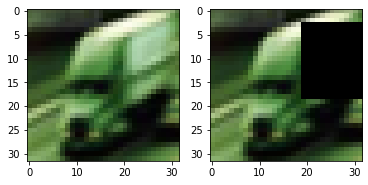

In [4]:
images, _ = next(iter(trainloader))
img = Cutout(1, 16)(images[0])

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(images[0].permute(1, 2, 0))
axes[1].imshow(img.permute(1, 2, 0))

### Model

In [5]:
import torch.nn as nn
import torch.nn.init as init
# We define all the classes and function regarding the ResNet architecture in this code cell
__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']
 
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202



### Hyperparameter Class

In [6]:
class MyResNetArgs:
   """
    Passing the hyperparameters to the model
   """
   def __init__(self, arch='resnet20' ,epochs=200, start_epoch=0, batch_size=128, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=55,
                 evaluate=0, pretrained=0, half=0, save_dir='save_temp', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.half = half #use half-precision(16-bit)
        self.evaluate = evaluate #evaluate model on the validation set
        self.pretrained = pretrained #evaluate the pretrained model on the validation set
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay
        self.momentum = momentum 
        self.lr = lr #Learning rate
        self.batch_size = batch_size 
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.arch = arch #ResNet model

### Initialization

In [7]:
from torchsummary import summary
args=MyResNetArgs('resnet44',pretrained=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = resnet44().to(device)
summary(model, (3,32,32))
best_prec1 = 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

### Training

In [8]:
import time

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)


def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    print_freq = 50
    
    # switch to train mode
    model.train()

    end = time.time()
    losses = []
    for i, (input, target) in enumerate(train_loader):

        target = target.cuda()
        input_var = input.cuda()
        target_var = target

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.item()
        losses.append(loss)
    
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time:.3f}\t'
                  'Loss {loss:.4f}\t'.format(
                      epoch, i, len(train_loader), batch_time=time.time() - end, loss=loss))
        
        # measure elapsed time
        end = time.time()
    
    return sum(losses) / len(losses)


def accuracy(val_loader, model, criterion):
    """
    Run evaluation
    """
    correct = 0
    total = 0
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (inp, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = inp.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            _, prediction = torch.max(output.data, 1)
            
            correct += (prediction == target).sum().item()
            total += target.size(0)

    return (100 * correct) // total

### Load Data

In [9]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
batch_size = 64

trainloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=True)

valloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=0, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### Q4.2

In [10]:
from datetime import datetime

def training_validation_error(trainloader, valloader, epochs, accuracy_threshold = None):
    lr, momentum, weight_decay = 0.1, 0.9, 1e-4

    model = resnet44()
    model.cuda()


    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80])
    val_error = []
    epochs_elapsed, start_time = 0, datetime.now()

    for epoch in range(epochs):
        epochs_elapsed += 1
        # train for one epoch
        print('Training Resnet-44 model')
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(trainloader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        epoch_accuracy = accuracy(valloader, model, criterion)
        val_error.append(100. - epoch_accuracy)
        
        if accuracy_threshold is not None and epoch_accuracy >= accuracy_threshold:
            break
        
    return val_error, epochs_elapsed, datetime.now() - start_time

epochs = 10
base_error, _, _ = training_validation_error(trainloader, valloader, epochs)

Training Resnet-44 model
current lr 1.00000e-01
Epoch: [0][0/782]	Time 0.191	Loss 3.3071	
Epoch: [0][50/782]	Time 0.046	Loss 2.3304	
Epoch: [0][100/782]	Time 0.048	Loss 2.1834	
Epoch: [0][150/782]	Time 0.046	Loss 1.9114	
Epoch: [0][200/782]	Time 0.046	Loss 1.8502	
Epoch: [0][250/782]	Time 0.046	Loss 1.8742	
Epoch: [0][300/782]	Time 0.048	Loss 1.6938	
Epoch: [0][350/782]	Time 0.046	Loss 1.6526	
Epoch: [0][400/782]	Time 0.048	Loss 1.8549	
Epoch: [0][450/782]	Time 0.048	Loss 1.7043	
Epoch: [0][500/782]	Time 0.048	Loss 1.6448	
Epoch: [0][550/782]	Time 0.048	Loss 1.7169	
Epoch: [0][600/782]	Time 0.048	Loss 1.7134	
Epoch: [0][650/782]	Time 0.046	Loss 1.6415	
Epoch: [0][700/782]	Time 0.048	Loss 1.4030	
Epoch: [0][750/782]	Time 0.048	Loss 1.3787	
Training Resnet-44 model
current lr 1.00000e-01
Epoch: [1][0/782]	Time 0.046	Loss 1.7329	
Epoch: [1][50/782]	Time 0.048	Loss 1.3637	
Epoch: [1][100/782]	Time 0.048	Loss 1.1871	
Epoch: [1][150/782]	Time 0.048	Loss 1.3258	
Epoch: [1][200/782]	Time 0.044

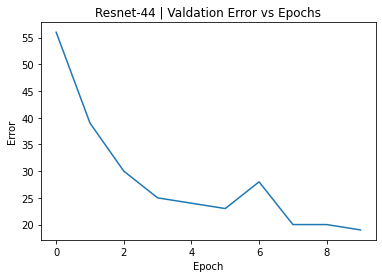

In [13]:
plt.plot(range(epochs), base_error)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Resnet-44 | Valdation Error vs Epochs")
plt.show()

### Q4.3
### Load Data with Cutout

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training Resnet-44 model
current lr 1.00000e-01
Epoch: [0][0/2344]	Time 0.265	Loss 5.0295	
Epoch: [0][50/2344]	Time 0.048	Loss 2.1978	
Epoch: [0][100/2344]	Time 0.050	Loss 2.1470	
Epoch: [0][150/2344]	Time 0.046	Loss 2.0238	
Epoch: [0][200/2344]	Time 0.050	Loss 1.8765	
Epoch: [0][250/2344]	Time 0.048	Loss 1.8862	
Epoch: [0][300/2344]	Time 0.046	Loss 1.8640	
Epoch: [0][350/2344]	Time 0.048	Loss 1.9053	
Epoch: [0][400/2344]	Time 0.048	Loss 1.8272	
Epoch: [0][450/2344]	Time 0.048	Loss 1.8010	
Epoch: [0][500/2344]	Time 0.050	Loss 1.8533	
Epoch: [0][550/2344]	Time 0.048	Loss 1.4252	
Epoch: [0][600/2344]	Time 0.048	Loss 1.7456	
Epoch: [0][650/2344]	Time 0.044	Loss 1.5738	
Epoch: [0][700/2344]	Time 0.052	Loss 1.5275	
Epoch: [0][750/2344]	Time 0.048	Loss 1.7562	
Epoch: [0][800/2344]	Time 0.048	Loss 1.6593	
Epoch: [0][850/2344]	Time 0.048	Loss 1.9408	
Epoch: [0][900/2344]	Time 0.046

Epoch: [3][1650/2344]	Time 0.046	Loss 0.4639	
Epoch: [3][1700/2344]	Time 0.046	Loss 0.7562	
Epoch: [3][1750/2344]	Time 0.050	Loss 0.4187	
Epoch: [3][1800/2344]	Time 0.048	Loss 0.3170	
Epoch: [3][1850/2344]	Time 0.048	Loss 0.3584	
Epoch: [3][1900/2344]	Time 0.050	Loss 0.7338	
Epoch: [3][1950/2344]	Time 0.046	Loss 0.5148	
Epoch: [3][2000/2344]	Time 0.048	Loss 0.4671	
Epoch: [3][2050/2344]	Time 0.048	Loss 0.6293	
Epoch: [3][2100/2344]	Time 0.050	Loss 0.4435	
Epoch: [3][2150/2344]	Time 0.050	Loss 0.3215	
Epoch: [3][2200/2344]	Time 0.048	Loss 0.3170	
Epoch: [3][2250/2344]	Time 0.048	Loss 0.2540	
Epoch: [3][2300/2344]	Time 0.048	Loss 0.4718	
Training Resnet-44 model
current lr 1.00000e-01
Epoch: [4][0/2344]	Time 0.052	Loss 0.2807	
Epoch: [4][50/2344]	Time 0.046	Loss 0.5181	
Epoch: [4][100/2344]	Time 0.048	Loss 0.2576	
Epoch: [4][150/2344]	Time 0.048	Loss 0.6971	
Epoch: [4][200/2344]	Time 0.048	Loss 0.3991	
Epoch: [4][250/2344]	Time 0.050	Loss 0.3405	
Epoch: [4][300/2344]	Time 0.046	Loss 0.56

Epoch: [7][1050/2344]	Time 0.046	Loss 0.4865	
Epoch: [7][1100/2344]	Time 0.050	Loss 0.2674	
Epoch: [7][1150/2344]	Time 0.050	Loss 0.3172	
Epoch: [7][1200/2344]	Time 0.046	Loss 0.4307	
Epoch: [7][1250/2344]	Time 0.046	Loss 0.4260	
Epoch: [7][1300/2344]	Time 0.046	Loss 0.4506	
Epoch: [7][1350/2344]	Time 0.047	Loss 0.3509	
Epoch: [7][1400/2344]	Time 0.046	Loss 0.3045	
Epoch: [7][1450/2344]	Time 0.046	Loss 0.2948	
Epoch: [7][1500/2344]	Time 0.048	Loss 0.2859	
Epoch: [7][1550/2344]	Time 0.046	Loss 0.3935	
Epoch: [7][1600/2344]	Time 0.050	Loss 0.3744	
Epoch: [7][1650/2344]	Time 0.046	Loss 0.3638	
Epoch: [7][1700/2344]	Time 0.046	Loss 0.3585	
Epoch: [7][1750/2344]	Time 0.050	Loss 0.4564	
Epoch: [7][1800/2344]	Time 0.048	Loss 0.3462	
Epoch: [7][1850/2344]	Time 0.048	Loss 0.3280	
Epoch: [7][1900/2344]	Time 0.048	Loss 0.4162	
Epoch: [7][1950/2344]	Time 0.050	Loss 0.2880	
Epoch: [7][2000/2344]	Time 0.050	Loss 0.4016	
Epoch: [7][2050/2344]	Time 0.046	Loss 0.5256	
Epoch: [7][2100/2344]	Time 0.047	L

Epoch: [0][2650/3907]	Time 0.049	Loss 0.7678	
Epoch: [0][2700/3907]	Time 0.050	Loss 0.8547	
Epoch: [0][2750/3907]	Time 0.046	Loss 0.6826	
Epoch: [0][2800/3907]	Time 0.046	Loss 0.8050	
Epoch: [0][2850/3907]	Time 0.048	Loss 1.1823	
Epoch: [0][2900/3907]	Time 0.046	Loss 0.8417	
Epoch: [0][2950/3907]	Time 0.048	Loss 0.8510	
Epoch: [0][3000/3907]	Time 0.048	Loss 0.7157	
Epoch: [0][3050/3907]	Time 0.049	Loss 0.7607	
Epoch: [0][3100/3907]	Time 0.052	Loss 0.8412	
Epoch: [0][3150/3907]	Time 0.046	Loss 0.4198	
Epoch: [0][3200/3907]	Time 0.046	Loss 0.7021	
Epoch: [0][3250/3907]	Time 0.048	Loss 0.9203	
Epoch: [0][3300/3907]	Time 0.048	Loss 0.9390	
Epoch: [0][3350/3907]	Time 0.047	Loss 0.8885	
Epoch: [0][3400/3907]	Time 0.048	Loss 0.9246	
Epoch: [0][3450/3907]	Time 0.050	Loss 0.9694	
Epoch: [0][3500/3907]	Time 0.046	Loss 0.6276	
Epoch: [0][3550/3907]	Time 0.050	Loss 0.5536	
Epoch: [0][3600/3907]	Time 0.050	Loss 0.9743	
Epoch: [0][3650/3907]	Time 0.050	Loss 0.6721	
Epoch: [0][3700/3907]	Time 0.046	L

Epoch: [2][3650/3907]	Time 0.048	Loss 0.4978	
Epoch: [2][3700/3907]	Time 0.048	Loss 0.2688	
Epoch: [2][3750/3907]	Time 0.048	Loss 0.3084	
Epoch: [2][3800/3907]	Time 0.048	Loss 0.4758	
Epoch: [2][3850/3907]	Time 0.046	Loss 0.5217	
Epoch: [2][3900/3907]	Time 0.046	Loss 0.4331	
Training Resnet-44 model
current lr 1.00000e-01
Epoch: [3][0/3907]	Time 0.056	Loss 0.4368	
Epoch: [3][50/3907]	Time 0.048	Loss 0.6259	
Epoch: [3][100/3907]	Time 0.048	Loss 0.2780	
Epoch: [3][150/3907]	Time 0.046	Loss 0.3139	
Epoch: [3][200/3907]	Time 0.050	Loss 0.3411	
Epoch: [3][250/3907]	Time 0.050	Loss 0.3150	
Epoch: [3][300/3907]	Time 0.050	Loss 0.2999	
Epoch: [3][350/3907]	Time 0.046	Loss 0.3307	
Epoch: [3][400/3907]	Time 0.048	Loss 0.2179	
Epoch: [3][450/3907]	Time 0.048	Loss 0.3529	
Epoch: [3][500/3907]	Time 0.046	Loss 0.4433	
Epoch: [3][550/3907]	Time 0.046	Loss 0.5028	
Epoch: [3][600/3907]	Time 0.050	Loss 0.6351	
Epoch: [3][650/3907]	Time 0.050	Loss 0.4775	
Epoch: [3][700/3907]	Time 0.050	Loss 0.2612	
Epoc

Epoch: [5][650/3907]	Time 0.048	Loss 0.2251	
Epoch: [5][700/3907]	Time 0.048	Loss 0.2980	
Epoch: [5][750/3907]	Time 0.046	Loss 0.1965	
Epoch: [5][800/3907]	Time 0.048	Loss 0.2662	
Epoch: [5][850/3907]	Time 0.050	Loss 0.2163	
Epoch: [5][900/3907]	Time 0.046	Loss 0.4777	
Epoch: [5][950/3907]	Time 0.048	Loss 0.2366	
Epoch: [5][1000/3907]	Time 0.046	Loss 0.3321	
Epoch: [5][1050/3907]	Time 0.046	Loss 0.2764	
Epoch: [5][1100/3907]	Time 0.050	Loss 0.4928	
Epoch: [5][1150/3907]	Time 0.048	Loss 0.3325	
Epoch: [5][1200/3907]	Time 0.050	Loss 0.2017	
Epoch: [5][1250/3907]	Time 0.050	Loss 0.3607	
Epoch: [5][1300/3907]	Time 0.046	Loss 0.4285	
Epoch: [5][1350/3907]	Time 0.048	Loss 0.4578	
Epoch: [5][1400/3907]	Time 0.046	Loss 0.4574	
Epoch: [5][1450/3907]	Time 0.050	Loss 0.3753	
Epoch: [5][1500/3907]	Time 0.048	Loss 0.2592	
Epoch: [5][1550/3907]	Time 0.050	Loss 0.3715	
Epoch: [5][1600/3907]	Time 0.044	Loss 0.2503	
Epoch: [5][1650/3907]	Time 0.046	Loss 0.2341	
Epoch: [5][1700/3907]	Time 0.046	Loss 0.3

Epoch: [7][1650/3907]	Time 0.044	Loss 0.4266	
Epoch: [7][1700/3907]	Time 0.050	Loss 0.3018	
Epoch: [7][1750/3907]	Time 0.046	Loss 0.5093	
Epoch: [7][1800/3907]	Time 0.050	Loss 0.3659	
Epoch: [7][1850/3907]	Time 0.046	Loss 0.2059	
Epoch: [7][1900/3907]	Time 0.048	Loss 0.2833	
Epoch: [7][1950/3907]	Time 0.046	Loss 0.1858	
Epoch: [7][2000/3907]	Time 0.048	Loss 0.2253	
Epoch: [7][2050/3907]	Time 0.048	Loss 0.2098	
Epoch: [7][2100/3907]	Time 0.048	Loss 0.3665	
Epoch: [7][2150/3907]	Time 0.046	Loss 0.3671	
Epoch: [7][2200/3907]	Time 0.048	Loss 0.4253	
Epoch: [7][2250/3907]	Time 0.046	Loss 0.3426	
Epoch: [7][2300/3907]	Time 0.050	Loss 0.4212	
Epoch: [7][2350/3907]	Time 0.048	Loss 0.2336	
Epoch: [7][2400/3907]	Time 0.050	Loss 0.3301	
Epoch: [7][2450/3907]	Time 0.048	Loss 0.4112	
Epoch: [7][2500/3907]	Time 0.050	Loss 0.3128	
Epoch: [7][2550/3907]	Time 0.048	Loss 0.3366	
Epoch: [7][2600/3907]	Time 0.048	Loss 0.1698	
Epoch: [7][2650/3907]	Time 0.044	Loss 0.4466	
Epoch: [7][2700/3907]	Time 0.050	L

Epoch: [9][2650/3907]	Time 0.044	Loss 0.3697	
Epoch: [9][2700/3907]	Time 0.048	Loss 0.2842	
Epoch: [9][2750/3907]	Time 0.050	Loss 0.2580	
Epoch: [9][2800/3907]	Time 0.050	Loss 0.4285	
Epoch: [9][2850/3907]	Time 0.048	Loss 0.3059	
Epoch: [9][2900/3907]	Time 0.046	Loss 0.2281	
Epoch: [9][2950/3907]	Time 0.048	Loss 0.3571	
Epoch: [9][3000/3907]	Time 0.046	Loss 0.2167	
Epoch: [9][3050/3907]	Time 0.046	Loss 0.1785	
Epoch: [9][3100/3907]	Time 0.048	Loss 0.2245	
Epoch: [9][3150/3907]	Time 0.048	Loss 0.3770	
Epoch: [9][3200/3907]	Time 0.046	Loss 0.1976	
Epoch: [9][3250/3907]	Time 0.048	Loss 0.1445	
Epoch: [9][3300/3907]	Time 0.048	Loss 0.3896	
Epoch: [9][3350/3907]	Time 0.046	Loss 0.3138	
Epoch: [9][3400/3907]	Time 0.046	Loss 0.2390	
Epoch: [9][3450/3907]	Time 0.048	Loss 0.4227	
Epoch: [9][3500/3907]	Time 0.050	Loss 0.2977	
Epoch: [9][3550/3907]	Time 0.050	Loss 0.3469	
Epoch: [9][3600/3907]	Time 0.048	Loss 0.3044	
Epoch: [9][3650/3907]	Time 0.048	Loss 0.4367	
Epoch: [9][3700/3907]	Time 0.048	L

Epoch: [1][150/7032]	Time 0.048	Loss 0.6090	
Epoch: [1][200/7032]	Time 0.050	Loss 0.6606	
Epoch: [1][250/7032]	Time 0.048	Loss 0.4713	
Epoch: [1][300/7032]	Time 0.048	Loss 0.4594	
Epoch: [1][350/7032]	Time 0.050	Loss 0.3034	
Epoch: [1][400/7032]	Time 0.044	Loss 0.6168	
Epoch: [1][450/7032]	Time 0.050	Loss 0.4026	
Epoch: [1][500/7032]	Time 0.046	Loss 0.3268	
Epoch: [1][550/7032]	Time 0.048	Loss 0.4123	
Epoch: [1][600/7032]	Time 0.046	Loss 0.4929	
Epoch: [1][650/7032]	Time 0.050	Loss 0.2527	
Epoch: [1][700/7032]	Time 0.048	Loss 0.3143	
Epoch: [1][750/7032]	Time 0.048	Loss 0.5193	
Epoch: [1][800/7032]	Time 0.046	Loss 0.5601	
Epoch: [1][850/7032]	Time 0.048	Loss 0.5164	
Epoch: [1][900/7032]	Time 0.046	Loss 0.5884	
Epoch: [1][950/7032]	Time 0.048	Loss 0.5522	
Epoch: [1][1000/7032]	Time 0.050	Loss 0.6937	
Epoch: [1][1050/7032]	Time 0.048	Loss 0.3895	
Epoch: [1][1100/7032]	Time 0.050	Loss 0.3339	
Epoch: [1][1150/7032]	Time 0.046	Loss 0.4793	
Epoch: [1][1200/7032]	Time 0.050	Loss 0.4725	
Epoch

Epoch: [2][2000/7032]	Time 0.048	Loss 0.5584	
Epoch: [2][2050/7032]	Time 0.046	Loss 0.3813	
Epoch: [2][2100/7032]	Time 0.046	Loss 0.3072	
Epoch: [2][2150/7032]	Time 0.048	Loss 0.3062	
Epoch: [2][2200/7032]	Time 0.046	Loss 0.4481	
Epoch: [2][2250/7032]	Time 0.050	Loss 0.4313	
Epoch: [2][2300/7032]	Time 0.048	Loss 0.2460	
Epoch: [2][2350/7032]	Time 0.048	Loss 0.3997	
Epoch: [2][2400/7032]	Time 0.048	Loss 0.3854	
Epoch: [2][2450/7032]	Time 0.050	Loss 0.3810	
Epoch: [2][2500/7032]	Time 0.046	Loss 0.4213	
Epoch: [2][2550/7032]	Time 0.044	Loss 0.3674	
Epoch: [2][2600/7032]	Time 0.047	Loss 0.1791	
Epoch: [2][2650/7032]	Time 0.048	Loss 0.3980	
Epoch: [2][2700/7032]	Time 0.048	Loss 0.2614	
Epoch: [2][2750/7032]	Time 0.050	Loss 0.3890	
Epoch: [2][2800/7032]	Time 0.052	Loss 0.3273	
Epoch: [2][2850/7032]	Time 0.050	Loss 0.3178	
Epoch: [2][2900/7032]	Time 0.048	Loss 0.3093	
Epoch: [2][2950/7032]	Time 0.050	Loss 0.3820	
Epoch: [2][3000/7032]	Time 0.048	Loss 0.4294	
Epoch: [2][3050/7032]	Time 0.050	L

Epoch: [3][3850/7032]	Time 0.046	Loss 0.1724	
Epoch: [3][3900/7032]	Time 0.046	Loss 0.3476	
Epoch: [3][3950/7032]	Time 0.048	Loss 0.3558	
Epoch: [3][4000/7032]	Time 0.048	Loss 0.3424	
Epoch: [3][4050/7032]	Time 0.048	Loss 0.2768	
Epoch: [3][4100/7032]	Time 0.050	Loss 0.2954	
Epoch: [3][4150/7032]	Time 0.047	Loss 0.2354	
Epoch: [3][4200/7032]	Time 0.046	Loss 0.2766	
Epoch: [3][4250/7032]	Time 0.048	Loss 0.2906	
Epoch: [3][4300/7032]	Time 0.046	Loss 0.1956	
Epoch: [3][4350/7032]	Time 0.046	Loss 0.4163	
Epoch: [3][4400/7032]	Time 0.048	Loss 0.1941	
Epoch: [3][4450/7032]	Time 0.048	Loss 0.1946	
Epoch: [3][4500/7032]	Time 0.048	Loss 0.1984	
Epoch: [3][4550/7032]	Time 0.050	Loss 0.3964	
Epoch: [3][4600/7032]	Time 0.048	Loss 0.4064	
Epoch: [3][4650/7032]	Time 0.048	Loss 0.3979	
Epoch: [3][4700/7032]	Time 0.050	Loss 0.3406	
Epoch: [3][4750/7032]	Time 0.048	Loss 0.3416	
Epoch: [3][4800/7032]	Time 0.048	Loss 0.5484	
Epoch: [3][4850/7032]	Time 0.048	Loss 0.2494	
Epoch: [3][4900/7032]	Time 0.048	L

Epoch: [4][5700/7032]	Time 0.050	Loss 0.3240	
Epoch: [4][5750/7032]	Time 0.048	Loss 0.2341	
Epoch: [4][5800/7032]	Time 0.048	Loss 0.3539	
Epoch: [4][5850/7032]	Time 0.046	Loss 0.1348	
Epoch: [4][5900/7032]	Time 0.048	Loss 0.2864	
Epoch: [4][5950/7032]	Time 0.048	Loss 0.1745	
Epoch: [4][6000/7032]	Time 0.050	Loss 0.2303	
Epoch: [4][6050/7032]	Time 0.050	Loss 0.2387	
Epoch: [4][6100/7032]	Time 0.048	Loss 0.2675	
Epoch: [4][6150/7032]	Time 0.047	Loss 0.1434	
Epoch: [4][6200/7032]	Time 0.046	Loss 0.2409	
Epoch: [4][6250/7032]	Time 0.048	Loss 0.2447	
Epoch: [4][6300/7032]	Time 0.048	Loss 0.2416	
Epoch: [4][6350/7032]	Time 0.050	Loss 0.5302	
Epoch: [4][6400/7032]	Time 0.047	Loss 0.2835	
Epoch: [4][6450/7032]	Time 0.046	Loss 0.2871	
Epoch: [4][6500/7032]	Time 0.048	Loss 0.2883	
Epoch: [4][6550/7032]	Time 0.046	Loss 0.3704	
Epoch: [4][6600/7032]	Time 0.046	Loss 0.2896	
Epoch: [4][6650/7032]	Time 0.048	Loss 0.4543	
Epoch: [4][6700/7032]	Time 0.048	Loss 0.2730	
Epoch: [4][6750/7032]	Time 0.048	L

Epoch: [6][450/7032]	Time 0.048	Loss 0.3609	
Epoch: [6][500/7032]	Time 0.048	Loss 0.1991	
Epoch: [6][550/7032]	Time 0.048	Loss 0.3044	
Epoch: [6][600/7032]	Time 0.048	Loss 0.3184	
Epoch: [6][650/7032]	Time 0.048	Loss 0.3633	
Epoch: [6][700/7032]	Time 0.045	Loss 0.2436	
Epoch: [6][750/7032]	Time 0.048	Loss 0.1549	
Epoch: [6][800/7032]	Time 0.046	Loss 0.1166	
Epoch: [6][850/7032]	Time 0.048	Loss 0.1452	
Epoch: [6][900/7032]	Time 0.048	Loss 0.1712	
Epoch: [6][950/7032]	Time 0.048	Loss 0.4461	
Epoch: [6][1000/7032]	Time 0.048	Loss 0.3679	
Epoch: [6][1050/7032]	Time 0.048	Loss 0.2243	
Epoch: [6][1100/7032]	Time 0.048	Loss 0.3306	
Epoch: [6][1150/7032]	Time 0.048	Loss 0.2028	
Epoch: [6][1200/7032]	Time 0.046	Loss 0.2808	
Epoch: [6][1250/7032]	Time 0.050	Loss 0.2866	
Epoch: [6][1300/7032]	Time 0.048	Loss 0.2922	
Epoch: [6][1350/7032]	Time 0.046	Loss 0.1644	
Epoch: [6][1400/7032]	Time 0.046	Loss 0.2771	
Epoch: [6][1450/7032]	Time 0.048	Loss 0.2735	
Epoch: [6][1500/7032]	Time 0.046	Loss 0.2456	

Epoch: [7][2300/7032]	Time 0.048	Loss 0.3258	
Epoch: [7][2350/7032]	Time 0.046	Loss 0.1789	
Epoch: [7][2400/7032]	Time 0.048	Loss 0.1728	
Epoch: [7][2450/7032]	Time 0.048	Loss 0.3745	
Epoch: [7][2500/7032]	Time 0.050	Loss 0.4028	
Epoch: [7][2550/7032]	Time 0.046	Loss 0.2819	
Epoch: [7][2600/7032]	Time 0.048	Loss 0.3046	
Epoch: [7][2650/7032]	Time 0.048	Loss 0.2806	
Epoch: [7][2700/7032]	Time 0.046	Loss 0.1285	
Epoch: [7][2750/7032]	Time 0.046	Loss 0.4026	
Epoch: [7][2800/7032]	Time 0.046	Loss 0.1504	
Epoch: [7][2850/7032]	Time 0.049	Loss 0.3763	
Epoch: [7][2900/7032]	Time 0.048	Loss 0.2714	
Epoch: [7][2950/7032]	Time 0.046	Loss 0.2932	
Epoch: [7][3000/7032]	Time 0.046	Loss 0.2673	
Epoch: [7][3050/7032]	Time 0.050	Loss 0.2864	
Epoch: [7][3100/7032]	Time 0.046	Loss 0.4571	
Epoch: [7][3150/7032]	Time 0.048	Loss 0.2395	
Epoch: [7][3200/7032]	Time 0.048	Loss 0.2461	
Epoch: [7][3250/7032]	Time 0.048	Loss 0.3773	
Epoch: [7][3300/7032]	Time 0.046	Loss 0.3121	
Epoch: [7][3350/7032]	Time 0.047	L

Epoch: [8][4150/7032]	Time 0.046	Loss 0.1362	
Epoch: [8][4200/7032]	Time 0.048	Loss 0.1456	
Epoch: [8][4250/7032]	Time 0.046	Loss 0.2762	
Epoch: [8][4300/7032]	Time 0.046	Loss 0.1721	
Epoch: [8][4350/7032]	Time 0.044	Loss 0.2529	
Epoch: [8][4400/7032]	Time 0.048	Loss 0.3115	
Epoch: [8][4450/7032]	Time 0.046	Loss 0.2899	
Epoch: [8][4500/7032]	Time 0.048	Loss 0.1783	
Epoch: [8][4550/7032]	Time 0.048	Loss 0.3310	
Epoch: [8][4600/7032]	Time 0.048	Loss 0.1820	
Epoch: [8][4650/7032]	Time 0.050	Loss 0.2318	
Epoch: [8][4700/7032]	Time 0.045	Loss 0.2012	
Epoch: [8][4750/7032]	Time 0.048	Loss 0.2938	
Epoch: [8][4800/7032]	Time 0.048	Loss 0.2991	
Epoch: [8][4850/7032]	Time 0.048	Loss 0.2451	
Epoch: [8][4900/7032]	Time 0.050	Loss 0.0592	
Epoch: [8][4950/7032]	Time 0.048	Loss 0.2825	
Epoch: [8][5000/7032]	Time 0.050	Loss 0.1996	
Epoch: [8][5050/7032]	Time 0.048	Loss 0.2259	
Epoch: [8][5100/7032]	Time 0.050	Loss 0.2282	
Epoch: [8][5150/7032]	Time 0.046	Loss 0.1275	
Epoch: [8][5200/7032]	Time 0.048	L

Epoch: [9][6000/7032]	Time 0.049	Loss 0.2888	
Epoch: [9][6050/7032]	Time 0.050	Loss 0.2666	
Epoch: [9][6100/7032]	Time 0.046	Loss 0.1522	
Epoch: [9][6150/7032]	Time 0.049	Loss 0.2715	
Epoch: [9][6200/7032]	Time 0.052	Loss 0.2417	
Epoch: [9][6250/7032]	Time 0.047	Loss 0.6101	
Epoch: [9][6300/7032]	Time 0.048	Loss 0.2057	
Epoch: [9][6350/7032]	Time 0.049	Loss 0.1702	
Epoch: [9][6400/7032]	Time 0.048	Loss 0.1062	
Epoch: [9][6450/7032]	Time 0.045	Loss 0.2493	
Epoch: [9][6500/7032]	Time 0.048	Loss 0.2350	
Epoch: [9][6550/7032]	Time 0.044	Loss 0.3292	
Epoch: [9][6600/7032]	Time 0.046	Loss 0.2580	
Epoch: [9][6650/7032]	Time 0.050	Loss 0.2840	
Epoch: [9][6700/7032]	Time 0.050	Loss 0.1476	
Epoch: [9][6750/7032]	Time 0.048	Loss 0.2784	
Epoch: [9][6800/7032]	Time 0.050	Loss 0.1398	
Epoch: [9][6850/7032]	Time 0.048	Loss 0.2602	
Epoch: [9][6900/7032]	Time 0.051	Loss 0.1867	
Epoch: [9][6950/7032]	Time 0.048	Loss 0.2022	
Epoch: [9][7000/7032]	Time 0.048	Loss 0.1369	
Files already downloaded and verif

Epoch: [0][7000/13282]	Time 0.048	Loss 0.4591	
Epoch: [0][7050/13282]	Time 0.050	Loss 0.5217	
Epoch: [0][7100/13282]	Time 0.048	Loss 0.4434	
Epoch: [0][7150/13282]	Time 0.050	Loss 0.7279	
Epoch: [0][7200/13282]	Time 0.050	Loss 0.6904	
Epoch: [0][7250/13282]	Time 0.048	Loss 0.5103	
Epoch: [0][7300/13282]	Time 0.048	Loss 0.5774	
Epoch: [0][7350/13282]	Time 0.046	Loss 0.8292	
Epoch: [0][7400/13282]	Time 0.048	Loss 0.4554	
Epoch: [0][7450/13282]	Time 0.050	Loss 0.6616	
Epoch: [0][7500/13282]	Time 0.050	Loss 0.5755	
Epoch: [0][7550/13282]	Time 0.048	Loss 0.5246	
Epoch: [0][7600/13282]	Time 0.046	Loss 0.4399	
Epoch: [0][7650/13282]	Time 0.048	Loss 0.3939	
Epoch: [0][7700/13282]	Time 0.050	Loss 0.4882	
Epoch: [0][7750/13282]	Time 0.048	Loss 0.5870	
Epoch: [0][7800/13282]	Time 0.049	Loss 0.4364	
Epoch: [0][7850/13282]	Time 0.048	Loss 0.7666	
Epoch: [0][7900/13282]	Time 0.048	Loss 0.4467	
Epoch: [0][7950/13282]	Time 0.048	Loss 0.4453	
Epoch: [0][8000/13282]	Time 0.048	Loss 0.5343	
Epoch: [0][80

Epoch: [1][2350/13282]	Time 0.062	Loss 0.3639	
Epoch: [1][2400/13282]	Time 0.046	Loss 0.3813	
Epoch: [1][2450/13282]	Time 0.047	Loss 0.4801	
Epoch: [1][2500/13282]	Time 0.047	Loss 0.2627	
Epoch: [1][2550/13282]	Time 0.047	Loss 0.6255	
Epoch: [1][2600/13282]	Time 0.047	Loss 0.5375	
Epoch: [1][2650/13282]	Time 0.047	Loss 0.3393	
Epoch: [1][2700/13282]	Time 0.047	Loss 0.5227	
Epoch: [1][2750/13282]	Time 0.047	Loss 0.3613	
Epoch: [1][2800/13282]	Time 0.047	Loss 0.2996	
Epoch: [1][2850/13282]	Time 0.047	Loss 0.3845	
Epoch: [1][2900/13282]	Time 0.047	Loss 0.3450	
Epoch: [1][2950/13282]	Time 0.047	Loss 0.3579	
Epoch: [1][3000/13282]	Time 0.047	Loss 0.3084	
Epoch: [1][3050/13282]	Time 0.047	Loss 0.3540	
Epoch: [1][3100/13282]	Time 0.047	Loss 0.4520	
Epoch: [1][3150/13282]	Time 0.051	Loss 0.2651	
Epoch: [1][3200/13282]	Time 0.047	Loss 0.3866	
Epoch: [1][3250/13282]	Time 0.047	Loss 0.4168	
Epoch: [1][3300/13282]	Time 0.047	Loss 0.3239	
Epoch: [1][3350/13282]	Time 0.047	Loss 0.3935	
Epoch: [1][34

Epoch: [1][11050/13282]	Time 0.040	Loss 0.2950	
Epoch: [1][11100/13282]	Time 0.047	Loss 0.2736	
Epoch: [1][11150/13282]	Time 0.047	Loss 0.2667	
Epoch: [1][11200/13282]	Time 0.047	Loss 0.3803	
Epoch: [1][11250/13282]	Time 0.047	Loss 0.3040	
Epoch: [1][11300/13282]	Time 0.047	Loss 0.2986	
Epoch: [1][11350/13282]	Time 0.047	Loss 0.7270	
Epoch: [1][11400/13282]	Time 0.047	Loss 0.2034	
Epoch: [1][11450/13282]	Time 0.047	Loss 0.2513	
Epoch: [1][11500/13282]	Time 0.047	Loss 0.1948	
Epoch: [1][11550/13282]	Time 0.047	Loss 0.5192	
Epoch: [1][11600/13282]	Time 0.047	Loss 0.3631	
Epoch: [1][11650/13282]	Time 0.047	Loss 0.2725	
Epoch: [1][11700/13282]	Time 0.047	Loss 0.3132	
Epoch: [1][11750/13282]	Time 0.047	Loss 0.3332	
Epoch: [1][11800/13282]	Time 0.047	Loss 0.4415	
Epoch: [1][11850/13282]	Time 0.047	Loss 0.2737	
Epoch: [1][11900/13282]	Time 0.047	Loss 0.3211	
Epoch: [1][11950/13282]	Time 0.047	Loss 0.2609	
Epoch: [1][12000/13282]	Time 0.047	Loss 0.2771	
Epoch: [1][12050/13282]	Time 0.047	Loss 

Epoch: [2][6400/13282]	Time 0.047	Loss 0.4088	
Epoch: [2][6450/13282]	Time 0.047	Loss 0.1916	
Epoch: [2][6500/13282]	Time 0.062	Loss 0.1801	
Epoch: [2][6550/13282]	Time 0.047	Loss 0.3117	
Epoch: [2][6600/13282]	Time 0.047	Loss 0.6625	
Epoch: [2][6650/13282]	Time 0.047	Loss 0.3630	
Epoch: [2][6700/13282]	Time 0.047	Loss 0.3772	
Epoch: [2][6750/13282]	Time 0.062	Loss 0.3447	
Epoch: [2][6800/13282]	Time 0.047	Loss 0.2541	
Epoch: [2][6850/13282]	Time 0.047	Loss 0.2227	
Epoch: [2][6900/13282]	Time 0.047	Loss 0.3639	
Epoch: [2][6950/13282]	Time 0.047	Loss 0.5143	
Epoch: [2][7000/13282]	Time 0.047	Loss 0.3200	
Epoch: [2][7050/13282]	Time 0.047	Loss 0.3590	
Epoch: [2][7100/13282]	Time 0.047	Loss 0.1853	
Epoch: [2][7150/13282]	Time 0.047	Loss 0.2367	
Epoch: [2][7200/13282]	Time 0.047	Loss 0.1951	
Epoch: [2][7250/13282]	Time 0.047	Loss 0.2662	
Epoch: [2][7300/13282]	Time 0.047	Loss 0.2965	
Epoch: [2][7350/13282]	Time 0.047	Loss 0.2149	
Epoch: [2][7400/13282]	Time 0.047	Loss 0.3645	
Epoch: [2][74

Epoch: [3][1750/13282]	Time 0.047	Loss 0.2555	
Epoch: [3][1800/13282]	Time 0.047	Loss 0.2998	
Epoch: [3][1850/13282]	Time 0.047	Loss 0.3147	
Epoch: [3][1900/13282]	Time 0.047	Loss 0.2300	
Epoch: [3][1950/13282]	Time 0.047	Loss 0.5580	
Epoch: [3][2000/13282]	Time 0.047	Loss 0.2775	
Epoch: [3][2050/13282]	Time 0.047	Loss 0.2795	
Epoch: [3][2100/13282]	Time 0.047	Loss 0.4868	
Epoch: [3][2150/13282]	Time 0.062	Loss 0.1547	
Epoch: [3][2200/13282]	Time 0.047	Loss 0.3074	
Epoch: [3][2250/13282]	Time 0.047	Loss 0.1304	
Epoch: [3][2300/13282]	Time 0.047	Loss 0.3377	
Epoch: [3][2350/13282]	Time 0.047	Loss 0.2894	
Epoch: [3][2400/13282]	Time 0.047	Loss 0.2215	
Epoch: [3][2450/13282]	Time 0.047	Loss 0.4632	
Epoch: [3][2500/13282]	Time 0.047	Loss 0.3238	
Epoch: [3][2550/13282]	Time 0.045	Loss 0.1513	
Epoch: [3][2600/13282]	Time 0.047	Loss 0.4150	
Epoch: [3][2650/13282]	Time 0.047	Loss 0.2561	
Epoch: [3][2700/13282]	Time 0.047	Loss 0.1373	
Epoch: [3][2750/13282]	Time 0.055	Loss 0.1900	
Epoch: [3][28

Epoch: [3][10500/13282]	Time 0.047	Loss 0.1654	
Epoch: [3][10550/13282]	Time 0.047	Loss 0.3204	
Epoch: [3][10600/13282]	Time 0.047	Loss 0.3100	
Epoch: [3][10650/13282]	Time 0.047	Loss 0.3290	
Epoch: [3][10700/13282]	Time 0.047	Loss 0.4367	
Epoch: [3][10750/13282]	Time 0.047	Loss 0.3251	
Epoch: [3][10800/13282]	Time 0.047	Loss 0.2808	
Epoch: [3][10850/13282]	Time 0.062	Loss 0.2374	
Epoch: [3][10900/13282]	Time 0.047	Loss 0.2262	
Epoch: [3][10950/13282]	Time 0.047	Loss 0.1651	
Epoch: [3][11000/13282]	Time 0.047	Loss 0.3889	
Epoch: [3][11050/13282]	Time 0.047	Loss 0.2274	
Epoch: [3][11100/13282]	Time 0.047	Loss 0.2984	
Epoch: [3][11150/13282]	Time 0.047	Loss 0.2663	
Epoch: [3][11200/13282]	Time 0.047	Loss 0.2828	
Epoch: [3][11250/13282]	Time 0.050	Loss 0.4244	
Epoch: [3][11300/13282]	Time 0.047	Loss 0.2530	
Epoch: [3][11350/13282]	Time 0.047	Loss 0.3425	
Epoch: [3][11400/13282]	Time 0.047	Loss 0.2756	
Epoch: [3][11450/13282]	Time 0.047	Loss 0.2590	
Epoch: [3][11500/13282]	Time 0.062	Loss 

Epoch: [4][5850/13282]	Time 0.047	Loss 0.3311	
Epoch: [4][5900/13282]	Time 0.050	Loss 0.1883	
Epoch: [4][5950/13282]	Time 0.047	Loss 0.3086	
Epoch: [4][6000/13282]	Time 0.047	Loss 0.1466	
Epoch: [4][6050/13282]	Time 0.047	Loss 0.3210	
Epoch: [4][6100/13282]	Time 0.047	Loss 0.3159	
Epoch: [4][6150/13282]	Time 0.047	Loss 0.2344	
Epoch: [4][6200/13282]	Time 0.047	Loss 0.2345	
Epoch: [4][6250/13282]	Time 0.047	Loss 0.1622	
Epoch: [4][6300/13282]	Time 0.047	Loss 0.3009	
Epoch: [4][6350/13282]	Time 0.047	Loss 0.1254	
Epoch: [4][6400/13282]	Time 0.047	Loss 0.3740	
Epoch: [4][6450/13282]	Time 0.047	Loss 0.1062	
Epoch: [4][6500/13282]	Time 0.047	Loss 0.2396	
Epoch: [4][6550/13282]	Time 0.047	Loss 0.2520	
Epoch: [4][6600/13282]	Time 0.047	Loss 0.4357	
Epoch: [4][6650/13282]	Time 0.047	Loss 0.4120	
Epoch: [4][6700/13282]	Time 0.047	Loss 0.1424	
Epoch: [4][6750/13282]	Time 0.047	Loss 0.3004	
Epoch: [4][6800/13282]	Time 0.047	Loss 0.4174	
Epoch: [4][6850/13282]	Time 0.047	Loss 0.2061	
Epoch: [4][69

Epoch: [5][1200/13282]	Time 0.047	Loss 0.3172	
Epoch: [5][1250/13282]	Time 0.047	Loss 0.1577	
Epoch: [5][1300/13282]	Time 0.047	Loss 0.3246	
Epoch: [5][1350/13282]	Time 0.047	Loss 0.1913	
Epoch: [5][1400/13282]	Time 0.047	Loss 0.2257	
Epoch: [5][1450/13282]	Time 0.047	Loss 0.1639	
Epoch: [5][1500/13282]	Time 0.047	Loss 0.3372	
Epoch: [5][1550/13282]	Time 0.047	Loss 0.1402	
Epoch: [5][1600/13282]	Time 0.047	Loss 0.1921	
Epoch: [5][1650/13282]	Time 0.047	Loss 0.2894	
Epoch: [5][1700/13282]	Time 0.047	Loss 0.3144	
Epoch: [5][1750/13282]	Time 0.047	Loss 0.2144	
Epoch: [5][1800/13282]	Time 0.047	Loss 0.3517	
Epoch: [5][1850/13282]	Time 0.047	Loss 0.2896	
Epoch: [5][1900/13282]	Time 0.047	Loss 0.4220	
Epoch: [5][1950/13282]	Time 0.047	Loss 0.1038	
Epoch: [5][2000/13282]	Time 0.047	Loss 0.2133	
Epoch: [5][2050/13282]	Time 0.047	Loss 0.3058	
Epoch: [5][2100/13282]	Time 0.047	Loss 0.2276	
Epoch: [5][2150/13282]	Time 0.047	Loss 0.1637	
Epoch: [5][2200/13282]	Time 0.047	Loss 0.3101	
Epoch: [5][22

Epoch: [5][9950/13282]	Time 0.047	Loss 0.3052	
Epoch: [5][10000/13282]	Time 0.062	Loss 0.2341	
Epoch: [5][10050/13282]	Time 0.047	Loss 0.2394	
Epoch: [5][10100/13282]	Time 0.047	Loss 0.3303	
Epoch: [5][10150/13282]	Time 0.062	Loss 0.4242	
Epoch: [5][10200/13282]	Time 0.047	Loss 0.3512	
Epoch: [5][10250/13282]	Time 0.047	Loss 0.1463	
Epoch: [5][10300/13282]	Time 0.047	Loss 0.2698	
Epoch: [5][10350/13282]	Time 0.047	Loss 0.3572	
Epoch: [5][10400/13282]	Time 0.047	Loss 0.2819	
Epoch: [5][10450/13282]	Time 0.047	Loss 0.3561	
Epoch: [5][10500/13282]	Time 0.062	Loss 0.1857	
Epoch: [5][10550/13282]	Time 0.047	Loss 0.2640	
Epoch: [5][10600/13282]	Time 0.047	Loss 0.3988	
Epoch: [5][10650/13282]	Time 0.047	Loss 0.2775	
Epoch: [5][10700/13282]	Time 0.047	Loss 0.1383	
Epoch: [5][10750/13282]	Time 0.047	Loss 0.4365	
Epoch: [5][10800/13282]	Time 0.047	Loss 0.2653	
Epoch: [5][10850/13282]	Time 0.047	Loss 0.2483	
Epoch: [5][10900/13282]	Time 0.047	Loss 0.2349	
Epoch: [5][10950/13282]	Time 0.047	Loss 0

Epoch: [6][5300/13282]	Time 0.047	Loss 0.2059	
Epoch: [6][5350/13282]	Time 0.047	Loss 0.3052	
Epoch: [6][5400/13282]	Time 0.047	Loss 0.2952	
Epoch: [6][5450/13282]	Time 0.047	Loss 0.3791	
Epoch: [6][5500/13282]	Time 0.047	Loss 0.2390	
Epoch: [6][5550/13282]	Time 0.047	Loss 0.2955	
Epoch: [6][5600/13282]	Time 0.047	Loss 0.3288	
Epoch: [6][5650/13282]	Time 0.047	Loss 0.2290	
Epoch: [6][5700/13282]	Time 0.047	Loss 0.2881	
Epoch: [6][5750/13282]	Time 0.047	Loss 0.2940	
Epoch: [6][5800/13282]	Time 0.047	Loss 0.3684	
Epoch: [6][5850/13282]	Time 0.047	Loss 0.2711	
Epoch: [6][5900/13282]	Time 0.047	Loss 0.2539	
Epoch: [6][5950/13282]	Time 0.047	Loss 0.1954	
Epoch: [6][6000/13282]	Time 0.062	Loss 0.1780	
Epoch: [6][6050/13282]	Time 0.047	Loss 0.2235	
Epoch: [6][6100/13282]	Time 0.047	Loss 0.1781	
Epoch: [6][6150/13282]	Time 0.047	Loss 0.2133	
Epoch: [6][6200/13282]	Time 0.047	Loss 0.2021	
Epoch: [6][6250/13282]	Time 0.047	Loss 0.3911	
Epoch: [6][6300/13282]	Time 0.047	Loss 0.2200	
Epoch: [6][63

Epoch: [7][650/13282]	Time 0.047	Loss 0.4649	
Epoch: [7][700/13282]	Time 0.047	Loss 0.1004	
Epoch: [7][750/13282]	Time 0.047	Loss 0.2818	
Epoch: [7][800/13282]	Time 0.047	Loss 0.1406	
Epoch: [7][850/13282]	Time 0.062	Loss 0.1541	
Epoch: [7][900/13282]	Time 0.047	Loss 0.2254	
Epoch: [7][950/13282]	Time 0.047	Loss 0.2972	
Epoch: [7][1000/13282]	Time 0.047	Loss 0.2291	
Epoch: [7][1050/13282]	Time 0.047	Loss 0.1993	
Epoch: [7][1100/13282]	Time 0.047	Loss 0.3521	
Epoch: [7][1150/13282]	Time 0.047	Loss 0.3352	
Epoch: [7][1200/13282]	Time 0.047	Loss 0.1828	
Epoch: [7][1250/13282]	Time 0.062	Loss 0.3501	
Epoch: [7][1300/13282]	Time 0.047	Loss 0.2477	
Epoch: [7][1350/13282]	Time 0.047	Loss 0.1299	
Epoch: [7][1400/13282]	Time 0.047	Loss 0.2472	
Epoch: [7][1450/13282]	Time 0.047	Loss 0.2998	
Epoch: [7][1500/13282]	Time 0.047	Loss 0.1656	
Epoch: [7][1550/13282]	Time 0.047	Loss 0.3211	
Epoch: [7][1600/13282]	Time 0.047	Loss 0.2145	
Epoch: [7][1650/13282]	Time 0.047	Loss 0.1495	
Epoch: [7][1700/1328

Epoch: [7][9400/13282]	Time 0.047	Loss 0.4205	
Epoch: [7][9450/13282]	Time 0.047	Loss 0.2210	
Epoch: [7][9500/13282]	Time 0.047	Loss 0.2538	
Epoch: [7][9550/13282]	Time 0.047	Loss 0.2506	
Epoch: [7][9600/13282]	Time 0.047	Loss 0.3148	
Epoch: [7][9650/13282]	Time 0.062	Loss 0.2841	
Epoch: [7][9700/13282]	Time 0.050	Loss 0.2283	
Epoch: [7][9750/13282]	Time 0.047	Loss 0.2833	
Epoch: [7][9800/13282]	Time 0.047	Loss 0.1303	
Epoch: [7][9850/13282]	Time 0.062	Loss 0.2341	
Epoch: [7][9900/13282]	Time 0.047	Loss 0.3998	
Epoch: [7][9950/13282]	Time 0.047	Loss 0.1935	
Epoch: [7][10000/13282]	Time 0.047	Loss 0.3937	
Epoch: [7][10050/13282]	Time 0.047	Loss 0.1701	
Epoch: [7][10100/13282]	Time 0.047	Loss 0.2231	
Epoch: [7][10150/13282]	Time 0.062	Loss 0.2736	
Epoch: [7][10200/13282]	Time 0.047	Loss 0.2184	
Epoch: [7][10250/13282]	Time 0.050	Loss 0.3623	
Epoch: [7][10300/13282]	Time 0.047	Loss 0.3639	
Epoch: [7][10350/13282]	Time 0.047	Loss 0.2296	
Epoch: [7][10400/13282]	Time 0.047	Loss 0.1869	
Epoc

Epoch: [8][4750/13282]	Time 0.047	Loss 0.2014	
Epoch: [8][4800/13282]	Time 0.047	Loss 0.3344	
Epoch: [8][4850/13282]	Time 0.047	Loss 0.1366	
Epoch: [8][4900/13282]	Time 0.047	Loss 0.2082	
Epoch: [8][4950/13282]	Time 0.054	Loss 0.4336	
Epoch: [8][5000/13282]	Time 0.047	Loss 0.0412	
Epoch: [8][5050/13282]	Time 0.047	Loss 0.1866	
Epoch: [8][5100/13282]	Time 0.047	Loss 0.1337	
Epoch: [8][5150/13282]	Time 0.047	Loss 0.2733	
Epoch: [8][5200/13282]	Time 0.047	Loss 0.1646	
Epoch: [8][5250/13282]	Time 0.047	Loss 0.3752	
Epoch: [8][5300/13282]	Time 0.047	Loss 0.1571	
Epoch: [8][5350/13282]	Time 0.060	Loss 0.1334	
Epoch: [8][5400/13282]	Time 0.050	Loss 0.1231	
Epoch: [8][5450/13282]	Time 0.052	Loss 0.1324	
Epoch: [8][5500/13282]	Time 0.040	Loss 0.2919	
Epoch: [8][5550/13282]	Time 0.047	Loss 0.2720	
Epoch: [8][5600/13282]	Time 0.047	Loss 0.2651	
Epoch: [8][5650/13282]	Time 0.062	Loss 0.1894	
Epoch: [8][5700/13282]	Time 0.047	Loss 0.2432	
Epoch: [8][5750/13282]	Time 0.047	Loss 0.1415	
Epoch: [8][58

Epoch: [9][50/13282]	Time 0.047	Loss 0.1951	
Epoch: [9][100/13282]	Time 0.047	Loss 0.2504	
Epoch: [9][150/13282]	Time 0.047	Loss 0.2241	
Epoch: [9][200/13282]	Time 0.047	Loss 0.1825	
Epoch: [9][250/13282]	Time 0.047	Loss 0.3056	
Epoch: [9][300/13282]	Time 0.047	Loss 0.1749	
Epoch: [9][350/13282]	Time 0.047	Loss 0.2820	
Epoch: [9][400/13282]	Time 0.047	Loss 0.1873	
Epoch: [9][450/13282]	Time 0.062	Loss 0.2850	
Epoch: [9][500/13282]	Time 0.047	Loss 0.1523	
Epoch: [9][550/13282]	Time 0.047	Loss 0.3020	
Epoch: [9][600/13282]	Time 0.047	Loss 0.4462	
Epoch: [9][650/13282]	Time 0.047	Loss 0.2605	
Epoch: [9][700/13282]	Time 0.047	Loss 0.2045	
Epoch: [9][750/13282]	Time 0.047	Loss 0.3581	
Epoch: [9][800/13282]	Time 0.047	Loss 0.1440	
Epoch: [9][850/13282]	Time 0.047	Loss 0.1712	
Epoch: [9][900/13282]	Time 0.047	Loss 0.3248	
Epoch: [9][950/13282]	Time 0.047	Loss 0.2266	
Epoch: [9][1000/13282]	Time 0.047	Loss 0.0845	
Epoch: [9][1050/13282]	Time 0.047	Loss 0.3340	
Epoch: [9][1100/13282]	Time 0.062

Epoch: [9][8800/13282]	Time 0.047	Loss 0.3129	
Epoch: [9][8850/13282]	Time 0.047	Loss 0.2561	
Epoch: [9][8900/13282]	Time 0.047	Loss 0.1236	
Epoch: [9][8950/13282]	Time 0.047	Loss 0.1396	
Epoch: [9][9000/13282]	Time 0.047	Loss 0.1627	
Epoch: [9][9050/13282]	Time 0.047	Loss 0.2191	
Epoch: [9][9100/13282]	Time 0.047	Loss 0.4303	
Epoch: [9][9150/13282]	Time 0.047	Loss 0.2835	
Epoch: [9][9200/13282]	Time 0.051	Loss 0.2918	
Epoch: [9][9250/13282]	Time 0.047	Loss 0.3209	
Epoch: [9][9300/13282]	Time 0.051	Loss 0.2333	
Epoch: [9][9350/13282]	Time 0.047	Loss 0.2679	
Epoch: [9][9400/13282]	Time 0.047	Loss 0.2229	
Epoch: [9][9450/13282]	Time 0.047	Loss 0.2847	
Epoch: [9][9500/13282]	Time 0.062	Loss 0.1669	
Epoch: [9][9550/13282]	Time 0.047	Loss 0.1759	
Epoch: [9][9600/13282]	Time 0.047	Loss 0.2251	
Epoch: [9][9650/13282]	Time 0.047	Loss 0.1264	
Epoch: [9][9700/13282]	Time 0.047	Loss 0.1798	
Epoch: [9][9750/13282]	Time 0.047	Loss 0.0948	
Epoch: [9][9800/13282]	Time 0.049	Loss 0.1828	
Epoch: [9][98

Epoch: [0][2800/25782]	Time 0.052	Loss 0.7857	
Epoch: [0][2850/25782]	Time 0.047	Loss 0.7142	
Epoch: [0][2900/25782]	Time 0.040	Loss 0.7448	
Epoch: [0][2950/25782]	Time 0.051	Loss 0.7997	
Epoch: [0][3000/25782]	Time 0.047	Loss 0.8304	
Epoch: [0][3050/25782]	Time 0.047	Loss 0.7076	
Epoch: [0][3100/25782]	Time 0.054	Loss 0.7869	
Epoch: [0][3150/25782]	Time 0.035	Loss 0.8669	
Epoch: [0][3200/25782]	Time 0.047	Loss 0.6682	
Epoch: [0][3250/25782]	Time 0.047	Loss 0.9189	
Epoch: [0][3300/25782]	Time 0.047	Loss 0.8739	
Epoch: [0][3350/25782]	Time 0.047	Loss 0.7885	
Epoch: [0][3400/25782]	Time 0.047	Loss 0.8137	
Epoch: [0][3450/25782]	Time 0.047	Loss 0.5865	
Epoch: [0][3500/25782]	Time 0.047	Loss 0.7868	
Epoch: [0][3550/25782]	Time 0.047	Loss 0.6228	
Epoch: [0][3600/25782]	Time 0.041	Loss 0.7525	
Epoch: [0][3650/25782]	Time 0.047	Loss 0.5840	
Epoch: [0][3700/25782]	Time 0.047	Loss 0.6432	
Epoch: [0][3750/25782]	Time 0.047	Loss 0.8660	
Epoch: [0][3800/25782]	Time 0.047	Loss 0.6380	
Epoch: [0][38

Epoch: [0][11500/25782]	Time 0.049	Loss 0.2768	
Epoch: [0][11550/25782]	Time 0.050	Loss 0.4587	
Epoch: [0][11600/25782]	Time 0.051	Loss 0.5490	
Epoch: [0][11650/25782]	Time 0.047	Loss 0.4965	
Epoch: [0][11700/25782]	Time 0.047	Loss 0.4302	
Epoch: [0][11750/25782]	Time 0.062	Loss 0.4654	
Epoch: [0][11800/25782]	Time 0.062	Loss 0.3837	
Epoch: [0][11850/25782]	Time 0.047	Loss 0.4164	
Epoch: [0][11900/25782]	Time 0.045	Loss 0.4140	
Epoch: [0][11950/25782]	Time 0.047	Loss 0.6004	
Epoch: [0][12000/25782]	Time 0.047	Loss 0.4143	
Epoch: [0][12050/25782]	Time 0.047	Loss 0.2255	
Epoch: [0][12100/25782]	Time 0.047	Loss 0.4895	
Epoch: [0][12150/25782]	Time 0.047	Loss 0.2787	
Epoch: [0][12200/25782]	Time 0.047	Loss 0.3364	
Epoch: [0][12250/25782]	Time 0.047	Loss 0.5018	
Epoch: [0][12300/25782]	Time 0.047	Loss 0.4065	
Epoch: [0][12350/25782]	Time 0.047	Loss 0.4762	
Epoch: [0][12400/25782]	Time 0.047	Loss 0.4623	
Epoch: [0][12450/25782]	Time 0.047	Loss 0.3374	
Epoch: [0][12500/25782]	Time 0.047	Loss 

Epoch: [0][20050/25782]	Time 0.047	Loss 0.3641	
Epoch: [0][20100/25782]	Time 0.047	Loss 0.3056	
Epoch: [0][20150/25782]	Time 0.047	Loss 0.4732	
Epoch: [0][20200/25782]	Time 0.047	Loss 0.4118	
Epoch: [0][20250/25782]	Time 0.047	Loss 0.5866	
Epoch: [0][20300/25782]	Time 0.047	Loss 0.3063	
Epoch: [0][20350/25782]	Time 0.047	Loss 0.2416	
Epoch: [0][20400/25782]	Time 0.047	Loss 0.4092	
Epoch: [0][20450/25782]	Time 0.047	Loss 0.3509	
Epoch: [0][20500/25782]	Time 0.047	Loss 0.4051	
Epoch: [0][20550/25782]	Time 0.047	Loss 0.4045	
Epoch: [0][20600/25782]	Time 0.047	Loss 0.3213	
Epoch: [0][20650/25782]	Time 0.047	Loss 0.2244	
Epoch: [0][20700/25782]	Time 0.047	Loss 0.4532	
Epoch: [0][20750/25782]	Time 0.047	Loss 0.3676	
Epoch: [0][20800/25782]	Time 0.047	Loss 0.2697	
Epoch: [0][20850/25782]	Time 0.047	Loss 0.4080	
Epoch: [0][20900/25782]	Time 0.063	Loss 0.3153	
Epoch: [0][20950/25782]	Time 0.047	Loss 0.2206	
Epoch: [0][21000/25782]	Time 0.047	Loss 0.3715	
Epoch: [0][21050/25782]	Time 0.047	Loss 

Epoch: [1][2850/25782]	Time 0.047	Loss 0.2396	
Epoch: [1][2900/25782]	Time 0.047	Loss 0.3844	
Epoch: [1][2950/25782]	Time 0.047	Loss 0.2555	
Epoch: [1][3000/25782]	Time 0.047	Loss 0.2856	
Epoch: [1][3050/25782]	Time 0.047	Loss 0.3727	
Epoch: [1][3100/25782]	Time 0.050	Loss 0.2658	
Epoch: [1][3150/25782]	Time 0.047	Loss 0.2213	
Epoch: [1][3200/25782]	Time 0.047	Loss 0.2722	
Epoch: [1][3250/25782]	Time 0.047	Loss 0.1788	
Epoch: [1][3300/25782]	Time 0.047	Loss 0.3769	
Epoch: [1][3350/25782]	Time 0.047	Loss 0.3622	
Epoch: [1][3400/25782]	Time 0.047	Loss 0.2880	
Epoch: [1][3450/25782]	Time 0.047	Loss 0.3214	
Epoch: [1][3500/25782]	Time 0.047	Loss 0.2269	
Epoch: [1][3550/25782]	Time 0.047	Loss 0.4035	
Epoch: [1][3600/25782]	Time 0.047	Loss 0.2021	
Epoch: [1][3650/25782]	Time 0.047	Loss 0.2464	
Epoch: [1][3700/25782]	Time 0.051	Loss 0.2099	
Epoch: [1][3750/25782]	Time 0.047	Loss 0.1097	
Epoch: [1][3800/25782]	Time 0.047	Loss 0.3999	
Epoch: [1][3850/25782]	Time 0.062	Loss 0.3080	
Epoch: [1][39

Epoch: [1][11550/25782]	Time 0.047	Loss 0.2226	
Epoch: [1][11600/25782]	Time 0.047	Loss 0.1629	
Epoch: [1][11650/25782]	Time 0.046	Loss 0.3153	
Epoch: [1][11700/25782]	Time 0.047	Loss 0.5379	
Epoch: [1][11750/25782]	Time 0.047	Loss 0.1869	
Epoch: [1][11800/25782]	Time 0.047	Loss 0.4115	
Epoch: [1][11850/25782]	Time 0.047	Loss 0.2113	
Epoch: [1][11900/25782]	Time 0.047	Loss 0.4222	
Epoch: [1][11950/25782]	Time 0.047	Loss 0.3606	
Epoch: [1][12000/25782]	Time 0.047	Loss 0.3088	
Epoch: [1][12050/25782]	Time 0.047	Loss 0.3817	
Epoch: [1][12100/25782]	Time 0.047	Loss 0.2765	
Epoch: [1][12150/25782]	Time 0.047	Loss 0.1629	
Epoch: [1][12200/25782]	Time 0.047	Loss 0.2896	
Epoch: [1][12250/25782]	Time 0.047	Loss 0.2234	
Epoch: [1][12300/25782]	Time 0.066	Loss 0.3823	
Epoch: [1][12350/25782]	Time 0.047	Loss 0.2337	
Epoch: [1][12400/25782]	Time 0.047	Loss 0.3387	
Epoch: [1][12450/25782]	Time 0.047	Loss 0.3313	
Epoch: [1][12500/25782]	Time 0.047	Loss 0.1968	
Epoch: [1][12550/25782]	Time 0.047	Loss 

Epoch: [1][20100/25782]	Time 0.047	Loss 0.3631	
Epoch: [1][20150/25782]	Time 0.047	Loss 0.2266	
Epoch: [1][20200/25782]	Time 0.047	Loss 0.2192	
Epoch: [1][20250/25782]	Time 0.047	Loss 0.2106	
Epoch: [1][20300/25782]	Time 0.047	Loss 0.1877	
Epoch: [1][20350/25782]	Time 0.047	Loss 0.2585	
Epoch: [1][20400/25782]	Time 0.047	Loss 0.2880	
Epoch: [1][20450/25782]	Time 0.062	Loss 0.2572	
Epoch: [1][20500/25782]	Time 0.047	Loss 0.2983	
Epoch: [1][20550/25782]	Time 0.047	Loss 0.2047	
Epoch: [1][20600/25782]	Time 0.047	Loss 0.4135	
Epoch: [1][20650/25782]	Time 0.047	Loss 0.2886	
Epoch: [1][20700/25782]	Time 0.047	Loss 0.2670	
Epoch: [1][20750/25782]	Time 0.047	Loss 0.4745	
Epoch: [1][20800/25782]	Time 0.047	Loss 0.3357	
Epoch: [1][20850/25782]	Time 0.047	Loss 0.2581	
Epoch: [1][20900/25782]	Time 0.047	Loss 0.2271	
Epoch: [1][20950/25782]	Time 0.047	Loss 0.3758	
Epoch: [1][21000/25782]	Time 0.047	Loss 0.3731	
Epoch: [1][21050/25782]	Time 0.047	Loss 0.3092	
Epoch: [1][21100/25782]	Time 0.047	Loss 

Epoch: [2][2900/25782]	Time 0.047	Loss 0.1765	
Epoch: [2][2950/25782]	Time 0.047	Loss 0.2807	
Epoch: [2][3000/25782]	Time 0.047	Loss 0.2962	
Epoch: [2][3050/25782]	Time 0.047	Loss 0.2445	
Epoch: [2][3100/25782]	Time 0.047	Loss 0.2171	
Epoch: [2][3150/25782]	Time 0.047	Loss 0.3953	
Epoch: [2][3200/25782]	Time 0.047	Loss 0.2864	
Epoch: [2][3250/25782]	Time 0.047	Loss 0.3018	
Epoch: [2][3300/25782]	Time 0.047	Loss 0.4528	
Epoch: [2][3350/25782]	Time 0.047	Loss 0.2410	
Epoch: [2][3400/25782]	Time 0.047	Loss 0.1803	
Epoch: [2][3450/25782]	Time 0.047	Loss 0.5790	
Epoch: [2][3500/25782]	Time 0.047	Loss 0.1613	
Epoch: [2][3550/25782]	Time 0.047	Loss 0.2228	
Epoch: [2][3600/25782]	Time 0.047	Loss 0.4722	
Epoch: [2][3650/25782]	Time 0.050	Loss 0.2186	
Epoch: [2][3700/25782]	Time 0.047	Loss 0.3634	
Epoch: [2][3750/25782]	Time 0.033	Loss 0.2757	
Epoch: [2][3800/25782]	Time 0.047	Loss 0.2585	
Epoch: [2][3850/25782]	Time 0.047	Loss 0.2562	
Epoch: [2][3900/25782]	Time 0.047	Loss 0.2029	
Epoch: [2][39

Epoch: [2][11600/25782]	Time 0.047	Loss 0.1908	
Epoch: [2][11650/25782]	Time 0.047	Loss 0.2312	
Epoch: [2][11700/25782]	Time 0.047	Loss 0.3967	
Epoch: [2][11750/25782]	Time 0.047	Loss 0.3495	
Epoch: [2][11800/25782]	Time 0.047	Loss 0.3492	
Epoch: [2][11850/25782]	Time 0.047	Loss 0.1758	
Epoch: [2][11900/25782]	Time 0.047	Loss 0.1683	
Epoch: [2][11950/25782]	Time 0.047	Loss 0.3049	
Epoch: [2][12000/25782]	Time 0.047	Loss 0.1729	
Epoch: [2][12050/25782]	Time 0.047	Loss 0.1492	
Epoch: [2][12100/25782]	Time 0.047	Loss 0.2034	
Epoch: [2][12150/25782]	Time 0.047	Loss 0.2806	
Epoch: [2][12200/25782]	Time 0.047	Loss 0.2880	
Epoch: [2][12250/25782]	Time 0.047	Loss 0.2312	
Epoch: [2][12300/25782]	Time 0.047	Loss 0.3088	
Epoch: [2][12350/25782]	Time 0.047	Loss 0.1820	
Epoch: [2][12400/25782]	Time 0.047	Loss 0.2673	
Epoch: [2][12450/25782]	Time 0.047	Loss 0.1640	
Epoch: [2][12500/25782]	Time 0.047	Loss 0.2301	
Epoch: [2][12550/25782]	Time 0.047	Loss 0.2254	
Epoch: [2][12600/25782]	Time 0.047	Loss 

Epoch: [2][20150/25782]	Time 0.047	Loss 0.2245	
Epoch: [2][20200/25782]	Time 0.047	Loss 0.2928	
Epoch: [2][20250/25782]	Time 0.047	Loss 0.3608	
Epoch: [2][20300/25782]	Time 0.047	Loss 0.3826	
Epoch: [2][20350/25782]	Time 0.047	Loss 0.2743	
Epoch: [2][20400/25782]	Time 0.047	Loss 0.2290	
Epoch: [2][20450/25782]	Time 0.047	Loss 0.2824	
Epoch: [2][20500/25782]	Time 0.047	Loss 0.1368	
Epoch: [2][20550/25782]	Time 0.047	Loss 0.2056	
Epoch: [2][20600/25782]	Time 0.047	Loss 0.4323	
Epoch: [2][20650/25782]	Time 0.047	Loss 0.2424	
Epoch: [2][20700/25782]	Time 0.051	Loss 0.2985	
Epoch: [2][20750/25782]	Time 0.047	Loss 0.3424	
Epoch: [2][20800/25782]	Time 0.047	Loss 0.1838	
Epoch: [2][20850/25782]	Time 0.047	Loss 0.1733	
Epoch: [2][20900/25782]	Time 0.047	Loss 0.2504	
Epoch: [2][20950/25782]	Time 0.047	Loss 0.2244	
Epoch: [2][21000/25782]	Time 0.047	Loss 0.1406	
Epoch: [2][21050/25782]	Time 0.047	Loss 0.1774	
Epoch: [2][21100/25782]	Time 0.047	Loss 0.4400	
Epoch: [2][21150/25782]	Time 0.047	Loss 

Epoch: [3][2950/25782]	Time 0.047	Loss 0.3833	
Epoch: [3][3000/25782]	Time 0.047	Loss 0.3201	
Epoch: [3][3050/25782]	Time 0.047	Loss 0.4600	
Epoch: [3][3100/25782]	Time 0.047	Loss 0.4039	
Epoch: [3][3150/25782]	Time 0.047	Loss 0.4651	
Epoch: [3][3200/25782]	Time 0.047	Loss 0.3882	
Epoch: [3][3250/25782]	Time 0.047	Loss 0.2569	
Epoch: [3][3300/25782]	Time 0.050	Loss 0.3484	
Epoch: [3][3350/25782]	Time 0.047	Loss 0.2402	
Epoch: [3][3400/25782]	Time 0.047	Loss 0.2799	
Epoch: [3][3450/25782]	Time 0.047	Loss 0.3176	
Epoch: [3][3500/25782]	Time 0.047	Loss 0.2626	
Epoch: [3][3550/25782]	Time 0.047	Loss 0.3038	
Epoch: [3][3600/25782]	Time 0.047	Loss 0.2549	
Epoch: [3][3650/25782]	Time 0.047	Loss 0.2979	
Epoch: [3][3700/25782]	Time 0.047	Loss 0.3030	
Epoch: [3][3750/25782]	Time 0.047	Loss 0.1710	
Epoch: [3][3800/25782]	Time 0.062	Loss 0.3430	
Epoch: [3][3850/25782]	Time 0.047	Loss 0.2488	
Epoch: [3][3900/25782]	Time 0.047	Loss 0.2840	
Epoch: [3][3950/25782]	Time 0.047	Loss 0.2320	
Epoch: [3][40

Epoch: [3][11650/25782]	Time 0.047	Loss 0.3180	
Epoch: [3][11700/25782]	Time 0.047	Loss 0.2983	
Epoch: [3][11750/25782]	Time 0.047	Loss 0.1415	
Epoch: [3][11800/25782]	Time 0.047	Loss 0.2549	
Epoch: [3][11850/25782]	Time 0.062	Loss 0.2252	
Epoch: [3][11900/25782]	Time 0.047	Loss 0.3822	
Epoch: [3][11950/25782]	Time 0.047	Loss 0.2090	
Epoch: [3][12000/25782]	Time 0.047	Loss 0.1366	
Epoch: [3][12050/25782]	Time 0.047	Loss 0.1220	
Epoch: [3][12100/25782]	Time 0.047	Loss 0.1585	
Epoch: [3][12150/25782]	Time 0.047	Loss 0.1477	
Epoch: [3][12200/25782]	Time 0.047	Loss 0.2330	
Epoch: [3][12250/25782]	Time 0.047	Loss 0.3374	
Epoch: [3][12300/25782]	Time 0.047	Loss 0.1555	
Epoch: [3][12350/25782]	Time 0.047	Loss 0.3724	
Epoch: [3][12400/25782]	Time 0.047	Loss 0.1910	
Epoch: [3][12450/25782]	Time 0.047	Loss 0.2838	
Epoch: [3][12500/25782]	Time 0.047	Loss 0.3093	
Epoch: [3][12550/25782]	Time 0.062	Loss 0.3713	
Epoch: [3][12600/25782]	Time 0.047	Loss 0.1137	
Epoch: [3][12650/25782]	Time 0.047	Loss 

Epoch: [3][20200/25782]	Time 0.047	Loss 0.1985	
Epoch: [3][20250/25782]	Time 0.047	Loss 0.4479	
Epoch: [3][20300/25782]	Time 0.044	Loss 0.1775	
Epoch: [3][20350/25782]	Time 0.062	Loss 0.2446	
Epoch: [3][20400/25782]	Time 0.047	Loss 0.2952	
Epoch: [3][20450/25782]	Time 0.047	Loss 0.2231	
Epoch: [3][20500/25782]	Time 0.047	Loss 0.3091	
Epoch: [3][20550/25782]	Time 0.062	Loss 0.3014	
Epoch: [3][20600/25782]	Time 0.047	Loss 0.2846	
Epoch: [3][20650/25782]	Time 0.047	Loss 0.3014	
Epoch: [3][20700/25782]	Time 0.047	Loss 0.2612	
Epoch: [3][20750/25782]	Time 0.047	Loss 0.2146	
Epoch: [3][20800/25782]	Time 0.047	Loss 0.2618	
Epoch: [3][20850/25782]	Time 0.047	Loss 0.2590	
Epoch: [3][20900/25782]	Time 0.047	Loss 0.1838	
Epoch: [3][20950/25782]	Time 0.047	Loss 0.1596	
Epoch: [3][21000/25782]	Time 0.047	Loss 0.2304	
Epoch: [3][21050/25782]	Time 0.047	Loss 0.1241	
Epoch: [3][21100/25782]	Time 0.047	Loss 0.1363	
Epoch: [3][21150/25782]	Time 0.047	Loss 0.2488	
Epoch: [3][21200/25782]	Time 0.047	Loss 

Epoch: [4][3000/25782]	Time 0.047	Loss 0.1836	
Epoch: [4][3050/25782]	Time 0.047	Loss 0.2526	
Epoch: [4][3100/25782]	Time 0.040	Loss 0.3647	
Epoch: [4][3150/25782]	Time 0.062	Loss 0.4362	
Epoch: [4][3200/25782]	Time 0.047	Loss 0.2801	
Epoch: [4][3250/25782]	Time 0.047	Loss 0.2218	
Epoch: [4][3300/25782]	Time 0.062	Loss 0.3625	
Epoch: [4][3350/25782]	Time 0.047	Loss 0.1572	
Epoch: [4][3400/25782]	Time 0.047	Loss 0.2570	
Epoch: [4][3450/25782]	Time 0.047	Loss 0.2296	
Epoch: [4][3500/25782]	Time 0.047	Loss 0.2303	
Epoch: [4][3550/25782]	Time 0.047	Loss 0.2209	
Epoch: [4][3600/25782]	Time 0.047	Loss 0.3014	
Epoch: [4][3650/25782]	Time 0.047	Loss 0.1062	
Epoch: [4][3700/25782]	Time 0.047	Loss 0.2435	
Epoch: [4][3750/25782]	Time 0.047	Loss 0.3626	
Epoch: [4][3800/25782]	Time 0.047	Loss 0.1414	
Epoch: [4][3850/25782]	Time 0.047	Loss 0.1957	
Epoch: [4][3900/25782]	Time 0.047	Loss 0.2112	
Epoch: [4][3950/25782]	Time 0.047	Loss 0.1447	
Epoch: [4][4000/25782]	Time 0.047	Loss 0.2523	
Epoch: [4][40

Epoch: [4][11700/25782]	Time 0.047	Loss 0.2774	
Epoch: [4][11750/25782]	Time 0.047	Loss 0.2052	
Epoch: [4][11800/25782]	Time 0.047	Loss 0.2360	
Epoch: [4][11850/25782]	Time 0.047	Loss 0.0726	
Epoch: [4][11900/25782]	Time 0.047	Loss 0.2593	
Epoch: [4][11950/25782]	Time 0.047	Loss 0.1313	
Epoch: [4][12000/25782]	Time 0.047	Loss 0.1427	
Epoch: [4][12050/25782]	Time 0.047	Loss 0.2903	
Epoch: [4][12100/25782]	Time 0.047	Loss 0.1191	
Epoch: [4][12150/25782]	Time 0.048	Loss 0.1571	
Epoch: [4][12200/25782]	Time 0.047	Loss 0.3463	
Epoch: [4][12250/25782]	Time 0.047	Loss 0.3124	
Epoch: [4][12300/25782]	Time 0.047	Loss 0.2070	
Epoch: [4][12350/25782]	Time 0.047	Loss 0.2757	
Epoch: [4][12400/25782]	Time 0.047	Loss 0.2213	
Epoch: [4][12450/25782]	Time 0.047	Loss 0.2135	
Epoch: [4][12500/25782]	Time 0.047	Loss 0.2007	
Epoch: [4][12550/25782]	Time 0.046	Loss 0.1723	
Epoch: [4][12600/25782]	Time 0.047	Loss 0.1572	
Epoch: [4][12650/25782]	Time 0.047	Loss 0.2831	
Epoch: [4][12700/25782]	Time 0.047	Loss 

Epoch: [4][20250/25782]	Time 0.062	Loss 0.1466	
Epoch: [4][20300/25782]	Time 0.047	Loss 0.2605	
Epoch: [4][20350/25782]	Time 0.047	Loss 0.3109	
Epoch: [4][20400/25782]	Time 0.049	Loss 0.0925	
Epoch: [4][20450/25782]	Time 0.047	Loss 0.3869	
Epoch: [4][20500/25782]	Time 0.047	Loss 0.3590	
Epoch: [4][20550/25782]	Time 0.047	Loss 0.1799	
Epoch: [4][20600/25782]	Time 0.047	Loss 0.2213	
Epoch: [4][20650/25782]	Time 0.047	Loss 0.1705	
Epoch: [4][20700/25782]	Time 0.047	Loss 0.2915	
Epoch: [4][20750/25782]	Time 0.062	Loss 0.2093	
Epoch: [4][20800/25782]	Time 0.047	Loss 0.2914	
Epoch: [4][20850/25782]	Time 0.047	Loss 0.2294	
Epoch: [4][20900/25782]	Time 0.047	Loss 0.2095	
Epoch: [4][20950/25782]	Time 0.047	Loss 0.1740	
Epoch: [4][21000/25782]	Time 0.050	Loss 0.2845	
Epoch: [4][21050/25782]	Time 0.051	Loss 0.1566	
Epoch: [4][21100/25782]	Time 0.047	Loss 0.2206	
Epoch: [4][21150/25782]	Time 0.047	Loss 0.3643	
Epoch: [4][21200/25782]	Time 0.047	Loss 0.3605	
Epoch: [4][21250/25782]	Time 0.047	Loss 

Epoch: [5][3050/25782]	Time 0.051	Loss 0.1380	
Epoch: [5][3100/25782]	Time 0.047	Loss 0.0589	
Epoch: [5][3150/25782]	Time 0.047	Loss 0.2660	
Epoch: [5][3200/25782]	Time 0.047	Loss 0.3820	
Epoch: [5][3250/25782]	Time 0.047	Loss 0.2211	
Epoch: [5][3300/25782]	Time 0.047	Loss 0.2116	
Epoch: [5][3350/25782]	Time 0.047	Loss 0.2506	
Epoch: [5][3400/25782]	Time 0.047	Loss 0.2397	
Epoch: [5][3450/25782]	Time 0.052	Loss 0.2543	
Epoch: [5][3500/25782]	Time 0.053	Loss 0.1551	
Epoch: [5][3550/25782]	Time 0.047	Loss 0.2886	
Epoch: [5][3600/25782]	Time 0.047	Loss 0.2877	
Epoch: [5][3650/25782]	Time 0.047	Loss 0.1640	
Epoch: [5][3700/25782]	Time 0.047	Loss 0.1971	
Epoch: [5][3750/25782]	Time 0.047	Loss 0.0989	
Epoch: [5][3800/25782]	Time 0.047	Loss 0.2077	
Epoch: [5][3850/25782]	Time 0.047	Loss 0.2795	
Epoch: [5][3900/25782]	Time 0.047	Loss 0.1016	
Epoch: [5][3950/25782]	Time 0.031	Loss 0.2126	
Epoch: [5][4000/25782]	Time 0.047	Loss 0.2471	
Epoch: [5][4050/25782]	Time 0.047	Loss 0.1843	
Epoch: [5][41

Epoch: [5][11750/25782]	Time 0.047	Loss 0.2091	
Epoch: [5][11800/25782]	Time 0.047	Loss 0.3737	
Epoch: [5][11850/25782]	Time 0.047	Loss 0.1842	
Epoch: [5][11900/25782]	Time 0.047	Loss 0.2818	
Epoch: [5][11950/25782]	Time 0.047	Loss 0.3324	
Epoch: [5][12000/25782]	Time 0.047	Loss 0.2078	
Epoch: [5][12050/25782]	Time 0.047	Loss 0.0975	
Epoch: [5][12100/25782]	Time 0.047	Loss 0.4201	
Epoch: [5][12150/25782]	Time 0.062	Loss 0.1310	
Epoch: [5][12200/25782]	Time 0.047	Loss 0.1792	
Epoch: [5][12250/25782]	Time 0.047	Loss 0.1054	
Epoch: [5][12300/25782]	Time 0.047	Loss 0.2763	
Epoch: [5][12350/25782]	Time 0.047	Loss 0.1812	
Epoch: [5][12400/25782]	Time 0.047	Loss 0.1636	
Epoch: [5][12450/25782]	Time 0.047	Loss 0.2057	
Epoch: [5][12500/25782]	Time 0.047	Loss 0.2872	
Epoch: [5][12550/25782]	Time 0.047	Loss 0.2648	
Epoch: [5][12600/25782]	Time 0.047	Loss 0.3217	
Epoch: [5][12650/25782]	Time 0.047	Loss 0.3951	
Epoch: [5][12700/25782]	Time 0.047	Loss 0.2362	
Epoch: [5][12750/25782]	Time 0.050	Loss 

Epoch: [5][20300/25782]	Time 0.047	Loss 0.3708	
Epoch: [5][20350/25782]	Time 0.047	Loss 0.2079	
Epoch: [5][20400/25782]	Time 0.047	Loss 0.1587	
Epoch: [5][20450/25782]	Time 0.062	Loss 0.1039	
Epoch: [5][20500/25782]	Time 0.062	Loss 0.3865	
Epoch: [5][20550/25782]	Time 0.047	Loss 0.1987	
Epoch: [5][20600/25782]	Time 0.047	Loss 0.1149	
Epoch: [5][20650/25782]	Time 0.047	Loss 0.1717	
Epoch: [5][20700/25782]	Time 0.047	Loss 0.2033	
Epoch: [5][20750/25782]	Time 0.047	Loss 0.2613	
Epoch: [5][20800/25782]	Time 0.047	Loss 0.3050	
Epoch: [5][20850/25782]	Time 0.047	Loss 0.2399	
Epoch: [5][20900/25782]	Time 0.047	Loss 0.1621	
Epoch: [5][20950/25782]	Time 0.047	Loss 0.1565	
Epoch: [5][21000/25782]	Time 0.047	Loss 0.1708	
Epoch: [5][21050/25782]	Time 0.047	Loss 0.2628	
Epoch: [5][21100/25782]	Time 0.047	Loss 0.3032	
Epoch: [5][21150/25782]	Time 0.047	Loss 0.2721	
Epoch: [5][21200/25782]	Time 0.047	Loss 0.2550	
Epoch: [5][21250/25782]	Time 0.047	Loss 0.2498	
Epoch: [5][21300/25782]	Time 0.047	Loss 

Epoch: [6][3100/25782]	Time 0.047	Loss 0.1410	
Epoch: [6][3150/25782]	Time 0.047	Loss 0.1317	
Epoch: [6][3200/25782]	Time 0.047	Loss 0.1096	
Epoch: [6][3250/25782]	Time 0.047	Loss 0.1740	
Epoch: [6][3300/25782]	Time 0.047	Loss 0.0918	
Epoch: [6][3350/25782]	Time 0.062	Loss 0.1321	
Epoch: [6][3400/25782]	Time 0.047	Loss 0.3396	
Epoch: [6][3450/25782]	Time 0.047	Loss 0.2598	
Epoch: [6][3500/25782]	Time 0.047	Loss 0.4355	
Epoch: [6][3550/25782]	Time 0.047	Loss 0.3177	
Epoch: [6][3600/25782]	Time 0.062	Loss 0.1708	
Epoch: [6][3650/25782]	Time 0.047	Loss 0.2476	
Epoch: [6][3700/25782]	Time 0.047	Loss 0.1735	
Epoch: [6][3750/25782]	Time 0.047	Loss 0.2236	
Epoch: [6][3800/25782]	Time 0.047	Loss 0.2314	
Epoch: [6][3850/25782]	Time 0.047	Loss 0.3936	
Epoch: [6][3900/25782]	Time 0.047	Loss 0.1827	
Epoch: [6][3950/25782]	Time 0.047	Loss 0.4101	
Epoch: [6][4000/25782]	Time 0.047	Loss 0.2165	
Epoch: [6][4050/25782]	Time 0.047	Loss 0.2102	
Epoch: [6][4100/25782]	Time 0.047	Loss 0.1995	
Epoch: [6][41

Epoch: [6][11800/25782]	Time 0.047	Loss 0.3196	
Epoch: [6][11850/25782]	Time 0.047	Loss 0.1530	
Epoch: [6][11900/25782]	Time 0.047	Loss 0.2814	
Epoch: [6][11950/25782]	Time 0.047	Loss 0.1528	
Epoch: [6][12000/25782]	Time 0.047	Loss 0.3079	
Epoch: [6][12050/25782]	Time 0.047	Loss 0.1739	
Epoch: [6][12100/25782]	Time 0.047	Loss 0.2827	
Epoch: [6][12150/25782]	Time 0.047	Loss 0.2323	
Epoch: [6][12200/25782]	Time 0.047	Loss 0.1831	
Epoch: [6][12250/25782]	Time 0.047	Loss 0.1953	
Epoch: [6][12300/25782]	Time 0.047	Loss 0.2320	
Epoch: [6][12350/25782]	Time 0.047	Loss 0.2108	
Epoch: [6][12400/25782]	Time 0.062	Loss 0.2494	
Epoch: [6][12450/25782]	Time 0.047	Loss 0.3901	
Epoch: [6][12500/25782]	Time 0.047	Loss 0.3046	
Epoch: [6][12550/25782]	Time 0.047	Loss 0.3171	
Epoch: [6][12600/25782]	Time 0.047	Loss 0.1027	
Epoch: [6][12650/25782]	Time 0.047	Loss 0.1724	
Epoch: [6][12700/25782]	Time 0.047	Loss 0.2576	
Epoch: [6][12750/25782]	Time 0.051	Loss 0.2760	
Epoch: [6][12800/25782]	Time 0.046	Loss 

Epoch: [6][20350/25782]	Time 0.047	Loss 0.3490	
Epoch: [6][20400/25782]	Time 0.047	Loss 0.1680	
Epoch: [6][20450/25782]	Time 0.047	Loss 0.3327	
Epoch: [6][20500/25782]	Time 0.047	Loss 0.2214	
Epoch: [6][20550/25782]	Time 0.047	Loss 0.1678	
Epoch: [6][20600/25782]	Time 0.047	Loss 0.1289	
Epoch: [6][20650/25782]	Time 0.047	Loss 0.2917	
Epoch: [6][20700/25782]	Time 0.047	Loss 0.2157	
Epoch: [6][20750/25782]	Time 0.047	Loss 0.1886	
Epoch: [6][20800/25782]	Time 0.047	Loss 0.1915	
Epoch: [6][20850/25782]	Time 0.047	Loss 0.1691	
Epoch: [6][20900/25782]	Time 0.047	Loss 0.1482	
Epoch: [6][20950/25782]	Time 0.047	Loss 0.2325	
Epoch: [6][21000/25782]	Time 0.047	Loss 0.1099	
Epoch: [6][21050/25782]	Time 0.047	Loss 0.3123	
Epoch: [6][21100/25782]	Time 0.047	Loss 0.4394	
Epoch: [6][21150/25782]	Time 0.047	Loss 0.3685	
Epoch: [6][21200/25782]	Time 0.047	Loss 0.3561	
Epoch: [6][21250/25782]	Time 0.047	Loss 0.2125	
Epoch: [6][21300/25782]	Time 0.047	Loss 0.2719	
Epoch: [6][21350/25782]	Time 0.047	Loss 

Epoch: [7][3150/25782]	Time 0.062	Loss 0.2331	
Epoch: [7][3200/25782]	Time 0.047	Loss 0.1387	
Epoch: [7][3250/25782]	Time 0.047	Loss 0.2089	
Epoch: [7][3300/25782]	Time 0.047	Loss 0.1007	
Epoch: [7][3350/25782]	Time 0.047	Loss 0.2668	
Epoch: [7][3400/25782]	Time 0.047	Loss 0.3295	
Epoch: [7][3450/25782]	Time 0.047	Loss 0.1863	
Epoch: [7][3500/25782]	Time 0.047	Loss 0.4611	
Epoch: [7][3550/25782]	Time 0.047	Loss 0.1560	
Epoch: [7][3600/25782]	Time 0.047	Loss 0.2609	
Epoch: [7][3650/25782]	Time 0.047	Loss 0.1453	
Epoch: [7][3700/25782]	Time 0.062	Loss 0.1617	
Epoch: [7][3750/25782]	Time 0.047	Loss 0.2370	
Epoch: [7][3800/25782]	Time 0.047	Loss 0.1425	
Epoch: [7][3850/25782]	Time 0.047	Loss 0.0592	
Epoch: [7][3900/25782]	Time 0.047	Loss 0.2109	
Epoch: [7][3950/25782]	Time 0.047	Loss 0.0810	
Epoch: [7][4000/25782]	Time 0.047	Loss 0.2200	
Epoch: [7][4050/25782]	Time 0.047	Loss 0.3487	
Epoch: [7][4100/25782]	Time 0.047	Loss 0.3176	
Epoch: [7][4150/25782]	Time 0.047	Loss 0.2606	
Epoch: [7][42

Epoch: [7][11850/25782]	Time 0.047	Loss 0.1182	
Epoch: [7][11900/25782]	Time 0.047	Loss 0.2249	
Epoch: [7][11950/25782]	Time 0.047	Loss 0.1535	
Epoch: [7][12000/25782]	Time 0.047	Loss 0.2095	
Epoch: [7][12050/25782]	Time 0.047	Loss 0.2098	
Epoch: [7][12100/25782]	Time 0.047	Loss 0.1653	
Epoch: [7][12150/25782]	Time 0.047	Loss 0.3292	
Epoch: [7][12200/25782]	Time 0.047	Loss 0.1802	
Epoch: [7][12250/25782]	Time 0.047	Loss 0.3201	
Epoch: [7][12300/25782]	Time 0.047	Loss 0.2083	
Epoch: [7][12350/25782]	Time 0.047	Loss 0.1262	
Epoch: [7][12400/25782]	Time 0.047	Loss 0.2410	
Epoch: [7][12450/25782]	Time 0.047	Loss 0.2047	
Epoch: [7][12500/25782]	Time 0.047	Loss 0.1680	
Epoch: [7][12550/25782]	Time 0.047	Loss 0.2627	
Epoch: [7][12600/25782]	Time 0.040	Loss 0.1988	
Epoch: [7][12650/25782]	Time 0.047	Loss 0.1506	
Epoch: [7][12700/25782]	Time 0.047	Loss 0.2689	
Epoch: [7][12750/25782]	Time 0.047	Loss 0.1690	
Epoch: [7][12800/25782]	Time 0.047	Loss 0.2115	
Epoch: [7][12850/25782]	Time 0.047	Loss 

Epoch: [7][20400/25782]	Time 0.047	Loss 0.2643	
Epoch: [7][20450/25782]	Time 0.047	Loss 0.2473	
Epoch: [7][20500/25782]	Time 0.062	Loss 0.2447	
Epoch: [7][20550/25782]	Time 0.047	Loss 0.3380	
Epoch: [7][20600/25782]	Time 0.047	Loss 0.1857	
Epoch: [7][20650/25782]	Time 0.047	Loss 0.1481	
Epoch: [7][20700/25782]	Time 0.050	Loss 0.1917	
Epoch: [7][20750/25782]	Time 0.062	Loss 0.2305	
Epoch: [7][20800/25782]	Time 0.047	Loss 0.3119	
Epoch: [7][20850/25782]	Time 0.047	Loss 0.2071	
Epoch: [7][20900/25782]	Time 0.047	Loss 0.2435	
Epoch: [7][20950/25782]	Time 0.047	Loss 0.3145	
Epoch: [7][21000/25782]	Time 0.047	Loss 0.1995	
Epoch: [7][21050/25782]	Time 0.047	Loss 0.2027	
Epoch: [7][21100/25782]	Time 0.047	Loss 0.1391	
Epoch: [7][21150/25782]	Time 0.047	Loss 0.1476	
Epoch: [7][21200/25782]	Time 0.047	Loss 0.2489	
Epoch: [7][21250/25782]	Time 0.063	Loss 0.2566	
Epoch: [7][21300/25782]	Time 0.047	Loss 0.1515	
Epoch: [7][21350/25782]	Time 0.047	Loss 0.2963	
Epoch: [7][21400/25782]	Time 0.047	Loss 

Epoch: [8][3200/25782]	Time 0.047	Loss 0.2276	
Epoch: [8][3250/25782]	Time 0.047	Loss 0.2168	
Epoch: [8][3300/25782]	Time 0.047	Loss 0.1305	
Epoch: [8][3350/25782]	Time 0.047	Loss 0.1321	
Epoch: [8][3400/25782]	Time 0.062	Loss 0.1814	
Epoch: [8][3450/25782]	Time 0.047	Loss 0.2076	
Epoch: [8][3500/25782]	Time 0.047	Loss 0.2652	
Epoch: [8][3550/25782]	Time 0.047	Loss 0.1482	
Epoch: [8][3600/25782]	Time 0.047	Loss 0.2980	
Epoch: [8][3650/25782]	Time 0.062	Loss 0.3164	
Epoch: [8][3700/25782]	Time 0.047	Loss 0.1895	
Epoch: [8][3750/25782]	Time 0.047	Loss 0.2445	
Epoch: [8][3800/25782]	Time 0.062	Loss 0.3450	
Epoch: [8][3850/25782]	Time 0.049	Loss 0.1916	
Epoch: [8][3900/25782]	Time 0.047	Loss 0.2129	
Epoch: [8][3950/25782]	Time 0.047	Loss 0.2211	
Epoch: [8][4000/25782]	Time 0.047	Loss 0.1721	
Epoch: [8][4050/25782]	Time 0.047	Loss 0.0763	
Epoch: [8][4100/25782]	Time 0.062	Loss 0.2098	
Epoch: [8][4150/25782]	Time 0.047	Loss 0.3082	
Epoch: [8][4200/25782]	Time 0.047	Loss 0.3310	
Epoch: [8][42

Epoch: [8][11900/25782]	Time 0.047	Loss 0.0934	
Epoch: [8][11950/25782]	Time 0.047	Loss 0.2676	
Epoch: [8][12000/25782]	Time 0.047	Loss 0.3390	
Epoch: [8][12050/25782]	Time 0.047	Loss 0.2419	
Epoch: [8][12100/25782]	Time 0.047	Loss 0.1485	
Epoch: [8][12150/25782]	Time 0.047	Loss 0.3048	
Epoch: [8][12200/25782]	Time 0.047	Loss 0.0933	
Epoch: [8][12250/25782]	Time 0.047	Loss 0.2799	
Epoch: [8][12300/25782]	Time 0.047	Loss 0.2098	
Epoch: [8][12350/25782]	Time 0.047	Loss 0.0904	
Epoch: [8][12400/25782]	Time 0.047	Loss 0.2389	
Epoch: [8][12450/25782]	Time 0.047	Loss 0.2091	
Epoch: [8][12500/25782]	Time 0.047	Loss 0.3943	
Epoch: [8][12550/25782]	Time 0.047	Loss 0.2611	
Epoch: [8][12600/25782]	Time 0.047	Loss 0.1357	
Epoch: [8][12650/25782]	Time 0.047	Loss 0.1733	
Epoch: [8][12700/25782]	Time 0.047	Loss 0.1791	
Epoch: [8][12750/25782]	Time 0.040	Loss 0.2330	
Epoch: [8][12800/25782]	Time 0.047	Loss 0.2163	
Epoch: [8][12850/25782]	Time 0.047	Loss 0.1657	
Epoch: [8][12900/25782]	Time 0.047	Loss 

Epoch: [8][20450/25782]	Time 0.047	Loss 0.2731	
Epoch: [8][20500/25782]	Time 0.047	Loss 0.3376	
Epoch: [8][20550/25782]	Time 0.047	Loss 0.2324	
Epoch: [8][20600/25782]	Time 0.047	Loss 0.2938	
Epoch: [8][20650/25782]	Time 0.047	Loss 0.3707	
Epoch: [8][20700/25782]	Time 0.047	Loss 0.2913	
Epoch: [8][20750/25782]	Time 0.047	Loss 0.4238	
Epoch: [8][20800/25782]	Time 0.047	Loss 0.1565	
Epoch: [8][20850/25782]	Time 0.047	Loss 0.0612	
Epoch: [8][20900/25782]	Time 0.047	Loss 0.1338	
Epoch: [8][20950/25782]	Time 0.047	Loss 0.2149	
Epoch: [8][21000/25782]	Time 0.047	Loss 0.0967	
Epoch: [8][21050/25782]	Time 0.047	Loss 0.1465	
Epoch: [8][21100/25782]	Time 0.047	Loss 0.2221	
Epoch: [8][21150/25782]	Time 0.047	Loss 0.1268	
Epoch: [8][21200/25782]	Time 0.047	Loss 0.3197	
Epoch: [8][21250/25782]	Time 0.047	Loss 0.1620	
Epoch: [8][21300/25782]	Time 0.047	Loss 0.3462	
Epoch: [8][21350/25782]	Time 0.047	Loss 0.1913	
Epoch: [8][21400/25782]	Time 0.047	Loss 0.1820	
Epoch: [8][21450/25782]	Time 0.047	Loss 

Epoch: [9][3250/25782]	Time 0.047	Loss 0.2352	
Epoch: [9][3300/25782]	Time 0.047	Loss 0.1523	
Epoch: [9][3350/25782]	Time 0.047	Loss 0.2294	
Epoch: [9][3400/25782]	Time 0.047	Loss 0.2421	
Epoch: [9][3450/25782]	Time 0.047	Loss 0.0848	
Epoch: [9][3500/25782]	Time 0.047	Loss 0.2620	
Epoch: [9][3550/25782]	Time 0.047	Loss 0.2179	
Epoch: [9][3600/25782]	Time 0.047	Loss 0.3241	
Epoch: [9][3650/25782]	Time 0.051	Loss 0.2421	
Epoch: [9][3700/25782]	Time 0.047	Loss 0.1557	
Epoch: [9][3750/25782]	Time 0.047	Loss 0.1297	
Epoch: [9][3800/25782]	Time 0.047	Loss 0.2197	
Epoch: [9][3850/25782]	Time 0.047	Loss 0.3449	
Epoch: [9][3900/25782]	Time 0.050	Loss 0.2522	
Epoch: [9][3950/25782]	Time 0.049	Loss 0.4329	
Epoch: [9][4000/25782]	Time 0.047	Loss 0.1720	
Epoch: [9][4050/25782]	Time 0.047	Loss 0.1025	
Epoch: [9][4100/25782]	Time 0.047	Loss 0.4600	
Epoch: [9][4150/25782]	Time 0.047	Loss 0.2959	
Epoch: [9][4200/25782]	Time 0.047	Loss 0.1457	
Epoch: [9][4250/25782]	Time 0.047	Loss 0.0847	
Epoch: [9][43

Epoch: [9][11950/25782]	Time 0.039	Loss 0.1106	
Epoch: [9][12000/25782]	Time 0.047	Loss 0.3263	
Epoch: [9][12050/25782]	Time 0.047	Loss 0.2905	
Epoch: [9][12100/25782]	Time 0.047	Loss 0.3042	
Epoch: [9][12150/25782]	Time 0.047	Loss 0.2741	
Epoch: [9][12200/25782]	Time 0.047	Loss 0.1229	
Epoch: [9][12250/25782]	Time 0.047	Loss 0.4409	
Epoch: [9][12300/25782]	Time 0.047	Loss 0.4068	
Epoch: [9][12350/25782]	Time 0.062	Loss 0.1989	
Epoch: [9][12400/25782]	Time 0.047	Loss 0.0960	
Epoch: [9][12450/25782]	Time 0.047	Loss 0.3016	
Epoch: [9][12500/25782]	Time 0.047	Loss 0.2548	
Epoch: [9][12550/25782]	Time 0.047	Loss 0.2471	
Epoch: [9][12600/25782]	Time 0.047	Loss 0.2737	
Epoch: [9][12650/25782]	Time 0.043	Loss 0.3220	
Epoch: [9][12700/25782]	Time 0.062	Loss 0.1631	
Epoch: [9][12750/25782]	Time 0.047	Loss 0.2528	
Epoch: [9][12800/25782]	Time 0.047	Loss 0.1364	
Epoch: [9][12850/25782]	Time 0.045	Loss 0.1369	
Epoch: [9][12900/25782]	Time 0.047	Loss 0.1399	
Epoch: [9][12950/25782]	Time 0.062	Loss 

Epoch: [9][20500/25782]	Time 0.047	Loss 0.2712	
Epoch: [9][20550/25782]	Time 0.047	Loss 0.1247	
Epoch: [9][20600/25782]	Time 0.047	Loss 0.3651	
Epoch: [9][20650/25782]	Time 0.047	Loss 0.3956	
Epoch: [9][20700/25782]	Time 0.047	Loss 0.3078	
Epoch: [9][20750/25782]	Time 0.062	Loss 0.1352	
Epoch: [9][20800/25782]	Time 0.047	Loss 0.1912	
Epoch: [9][20850/25782]	Time 0.047	Loss 0.2073	
Epoch: [9][20900/25782]	Time 0.047	Loss 0.2502	
Epoch: [9][20950/25782]	Time 0.047	Loss 0.1876	
Epoch: [9][21000/25782]	Time 0.047	Loss 0.2080	
Epoch: [9][21050/25782]	Time 0.062	Loss 0.2453	
Epoch: [9][21100/25782]	Time 0.047	Loss 0.2395	
Epoch: [9][21150/25782]	Time 0.050	Loss 0.2754	
Epoch: [9][21200/25782]	Time 0.047	Loss 0.1579	
Epoch: [9][21250/25782]	Time 0.052	Loss 0.3403	
Epoch: [9][21300/25782]	Time 0.047	Loss 0.0844	
Epoch: [9][21350/25782]	Time 0.051	Loss 0.2142	
Epoch: [9][21400/25782]	Time 0.047	Loss 0.0747	
Epoch: [9][21450/25782]	Time 0.052	Loss 0.1375	
Epoch: [9][21500/25782]	Time 0.047	Loss 

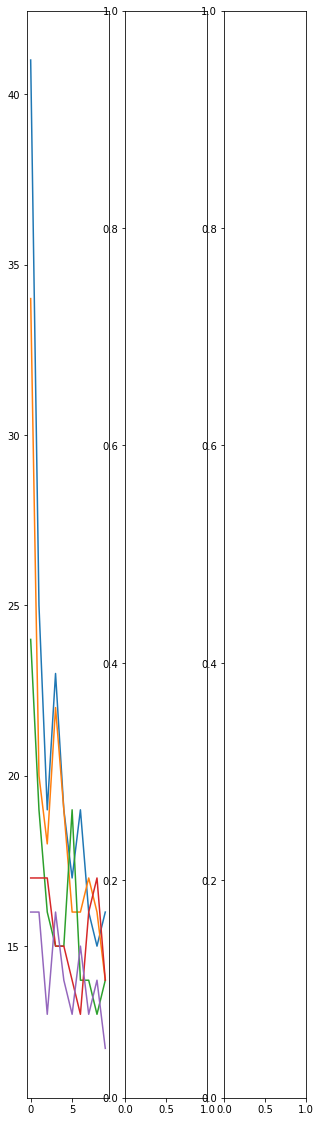

In [14]:
from torch.utils.data import ConcatDataset

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 64
epochs = 10

n_holes = [2,4,8,16,32]
epochs_till_94, runtime_till_94 = [],  []

fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

for holes in n_holes:
    # Base training set with no augmentations
    transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(32, 4),
                transforms.ToTensor(),
                normalize,
            ])
    augmented_trainset = [torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)]
    
    # Add new augmented data to training set
    for _ in range(holes):
        augmentations = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(32, 4),
                    transforms.ToTensor(),
                    normalize,
                    Cutout(holes, 16)
                ])
        augmented_trainset.append(torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform))
    
    # Merge all variations of the dataset into one
    trainset = ConcatDataset(augmented_trainset)
    
    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True,
            num_workers=0, pin_memory=True)

    valloader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=128, shuffle=False,
            num_workers=0, pin_memory=True)
    
    cutout_error, epochs_elapsed, runtime = training_validation_error(trainloader, valloader, epochs, accuracy_threshold = 94)
    epochs_till_94.append(epochs_elapsed)
    runtime_till_94.append(runtime.total_seconds())
    
#     plt.plot(range(epochs), training_losses, label="Training")
    axes[0].plot(range(epochs_elapsed), cutout_error, label=f"M = {holes}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Error")
axes[0].set_title("Resnet-44 | Error vs Epochs")
axes[0].legend(loc="best")

axes[1].plot(n_holes, epochs_till_94)
axes[1].set_xlabel(r"$M$")
axes[1].set_ylabel("Epochs")
axes[1].set_title("Epochs taken to reach 94% accuracy")

axes[2].set_title("Time take to reach 94% accuracy")
axes[2].plot(n_holes, runtime_till_94)
axes[2].set_xlabel(r"$M$")
axes[2].set_ylabel("Time(s)")
fig.show()

In [16]:
from utils.notification.emailer import *

msg = message.email(text="Training Done.", subject="IDLS Lab Notebook Notification")
mail_io.send(msg, server="smtp.gmail.com")